In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
%cd /content

/content


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, BatchNormalization,Dropout
import matplotlib.pyplot as plt
from keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 180
img_size = 48

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.


In [ ]:
from keras.optimizers import Adam,SGD,RMSprop

initializer = tf.keras.initializers.HeUniform(seed=42)
reg = tf.keras.regularizers.L2(l2=0.01)
no_of_classes = 5

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same', activation='relu',input_shape = (48,48,1), kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

Epoch : **5**

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 2

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size
                                )

Epoch 1/2
46/46 [==============================] - 2906s 63s/step - loss: 26.2888 - accuracy: 0.2584 - val_loss: 25.4836 - val_accuracy: 0.2600
Epoch 2/2
46/46 [==============================] - 435s 9s/step - loss: 25.4587 - accuracy: 0.3471 - val_loss: 25.0120 - val_accuracy: 0.2822


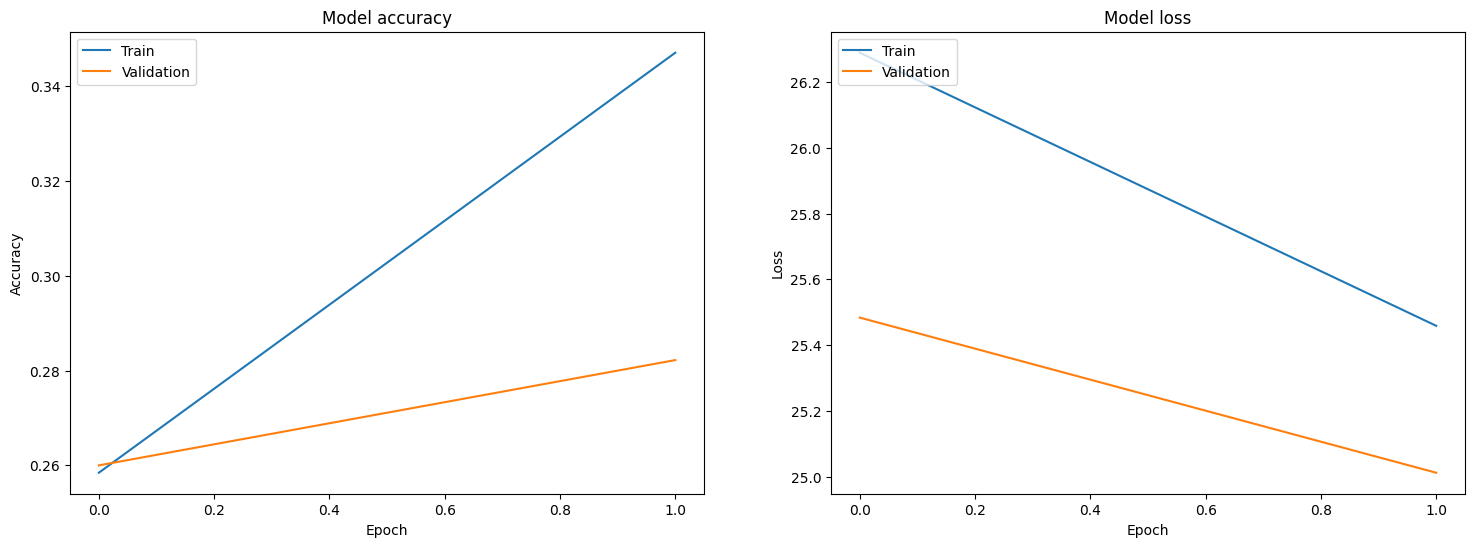

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
DB_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=DB_labels, title='Normalized confusion matrix')
plt.show()

In [ ]:
history = model.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size
                                )

Epoch 1/5
 9/46 [====>.........................] - ETA: 13:57 - loss: 26.3146 - accuracy: 0.2642

In [ ]:
model.save('custom_modelv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


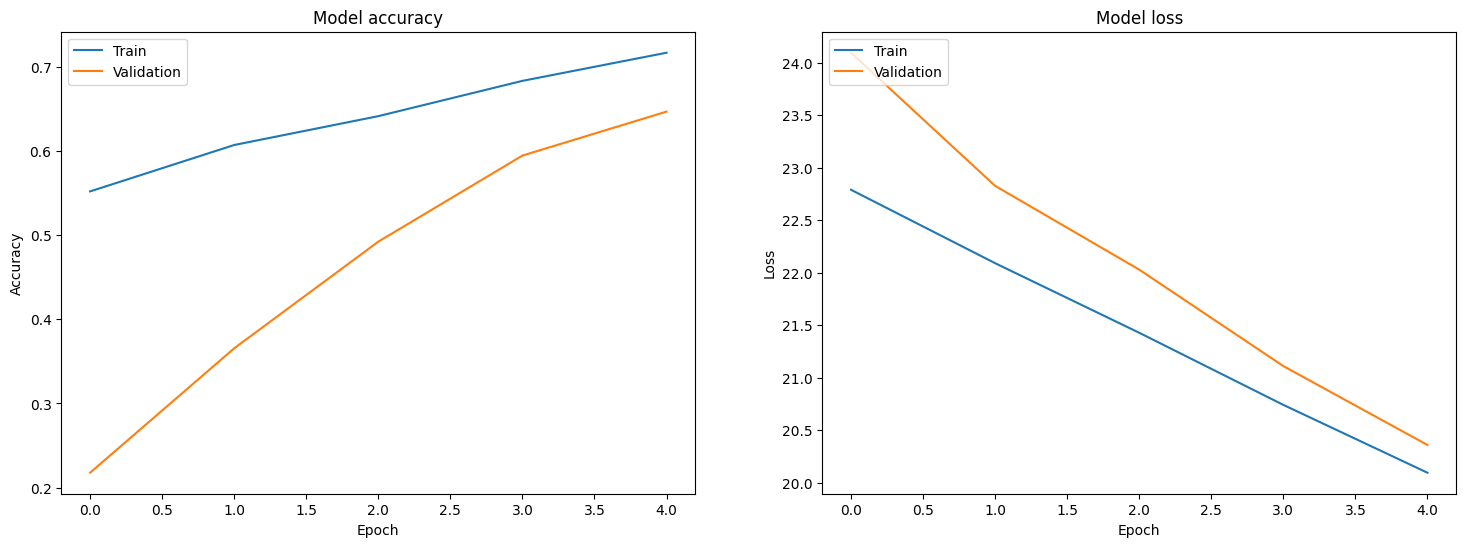

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

6/6 [==============================] - 8s 1s/step


<Figure size 640x480 with 0 Axes>

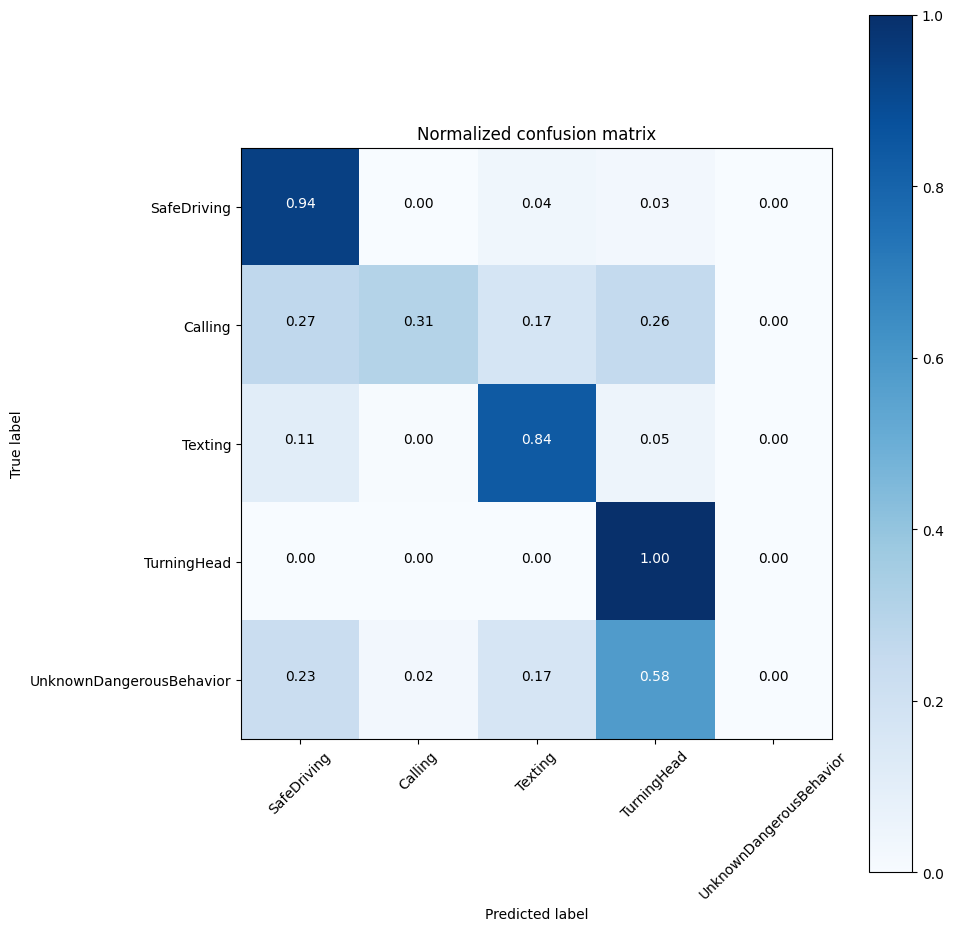

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
DB_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=DB_labels, title='Normalized confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score

# Assuming you have the actual labels (y_true) and predicted labels (y_pred)
# These labels should be based on the confusion matrix from your problem

# Calculate the confusion matrix
cm = confusion_matrix(y_pred, y_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_pred, y_test)

# Calculate F1-score
f1 = f1_score(y_pred, y_test, average='micro')

# Calculate precision
precision = precision_score(y_pred, y_test, average='micro')

# Print the results
print("Confusion Matrix:")
print(cm)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))

Confusion Matrix:
[[218  57  23   0  47]
 [  0  66   1   0   5]
 [  9  36 183   0  34]
 [  6  55  11 199 118]
 [  0   0   0   0   0]]
Overall Accuracy: 62.36%
F1-Score: 0.62
Precision: 0.62


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
batch_size = 180
img_size = 48

# Training data generator without validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validation data generator without validation split
validation_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory for training data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

# Flow from directory for validation data
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

# Flow from directory for test data
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)



Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.


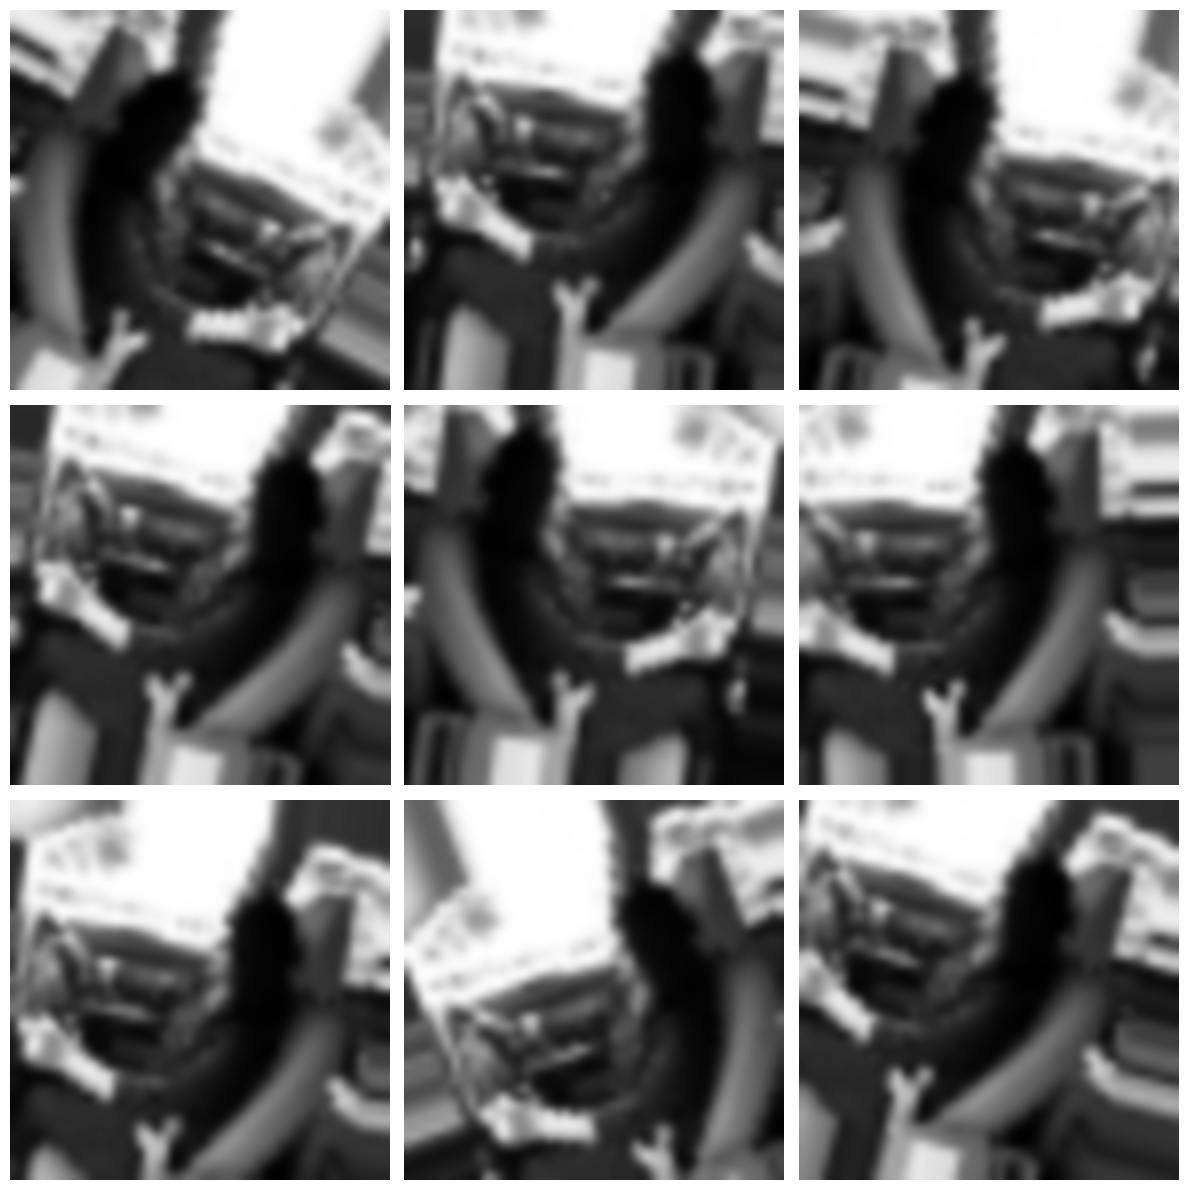

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Sample image to visualize augmentations
sample_image_path = '/content/drive/MyDrive/NEW DATASET/train/0/img_100050.jpg'  # Replace with an actual image path

# Load a sample image
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
sample_image = cv2.resize(sample_image, (img_size, img_size))  # Resize to desired dimensions

# Create a figure to display the augmented images (larger size)
plt.figure(figsize=(12, 12))

# Plot each augmentation separately
i = 1
for batch in train_datagen.flow(sample_image.reshape(1, img_size, img_size, 1), batch_size=1):
    plt.subplot(3, 3, i)
    plt.imshow(batch[0].reshape(img_size, img_size), cmap='gray', interpolation='bicubic')  # Using bicubic interpolation
    plt.axis('off')
    i += 1
    if i > 9:
        break  # Show 9 augmented versions

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



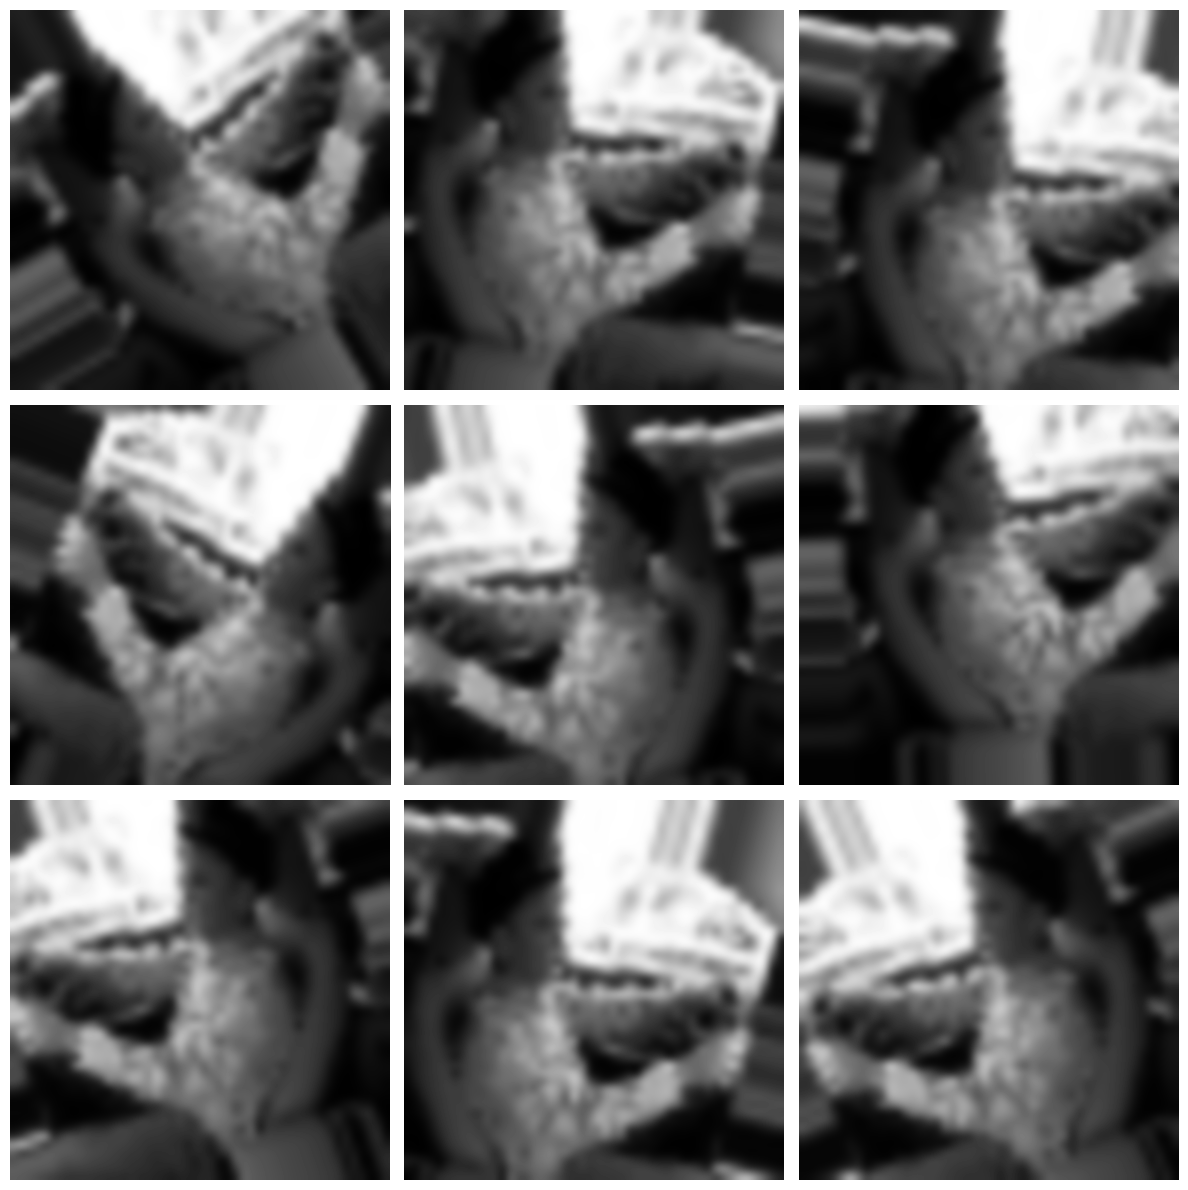

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Sample image to visualize augmentations
sample_image_path = '/content/drive/MyDrive/NEW DATASET/train/0/img_1039.jpg'  # Replace with an actual image path

# Load a sample image
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
sample_image = cv2.resize(sample_image, (img_size, img_size))  # Resize to desired dimensions

# Create a figure to display the augmented images (larger size)
plt.figure(figsize=(12, 12))

# Plot each augmentation separately
i = 1
for batch in train_datagen.flow(sample_image.reshape(1, img_size, img_size, 1), batch_size=1):
    plt.subplot(3, 3, i)
    plt.imshow(batch[0].reshape(img_size, img_size), cmap='gray', interpolation='bicubic')  # Using bicubic interpolation
    plt.axis('off')
    i += 1
    if i > 9:
        break  # Show 9 augmented versions

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


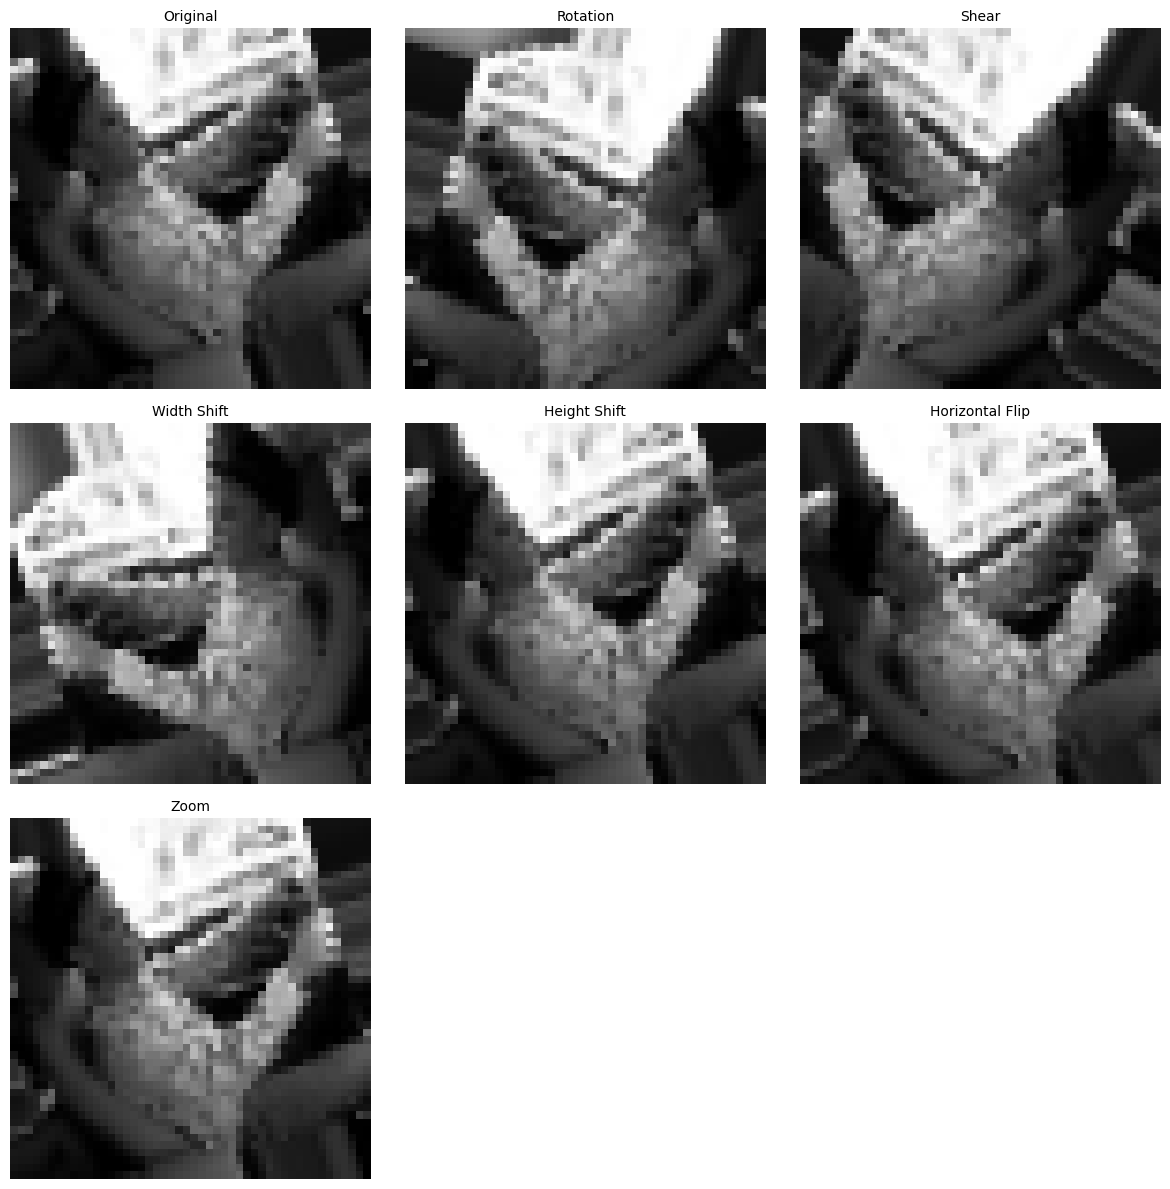

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Sample image to visualize augmentations
sample_image_path = '/content/drive/MyDrive/NEW DATASET/train/0/img_1039.jpg'  # Replace with an actual image path

# Load a sample image
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
sample_image = cv2.resize(sample_image, (img_size, img_size))  # Resize to desired dimensions

# Create a figure to display the augmented images
plt.figure(figsize=(12, 12))

# Define augmentation labels
augmentation_labels = [
    'Original', 'Rotation', 'Shear', 'Width Shift',
    'Height Shift', 'Horizontal Flip', 'Zoom'
]

# Plot each augmentation separately
i = 1
for batch, label in zip(
    train_datagen.flow(
        sample_image.reshape(1, img_size, img_size, 1),
        batch_size=1
    ),
    augmentation_labels
):
    plt.subplot(3, 3, i)
    plt.imshow(batch[0].reshape(img_size, img_size), cmap='gray')  # Assuming 'grayscale' color_mode
    plt.title(label, fontsize=10)
    plt.axis('off')
    i += 1
    if i > 9:
        break  # Show 9 augmented versions

plt.tight_layout()
plt.show()


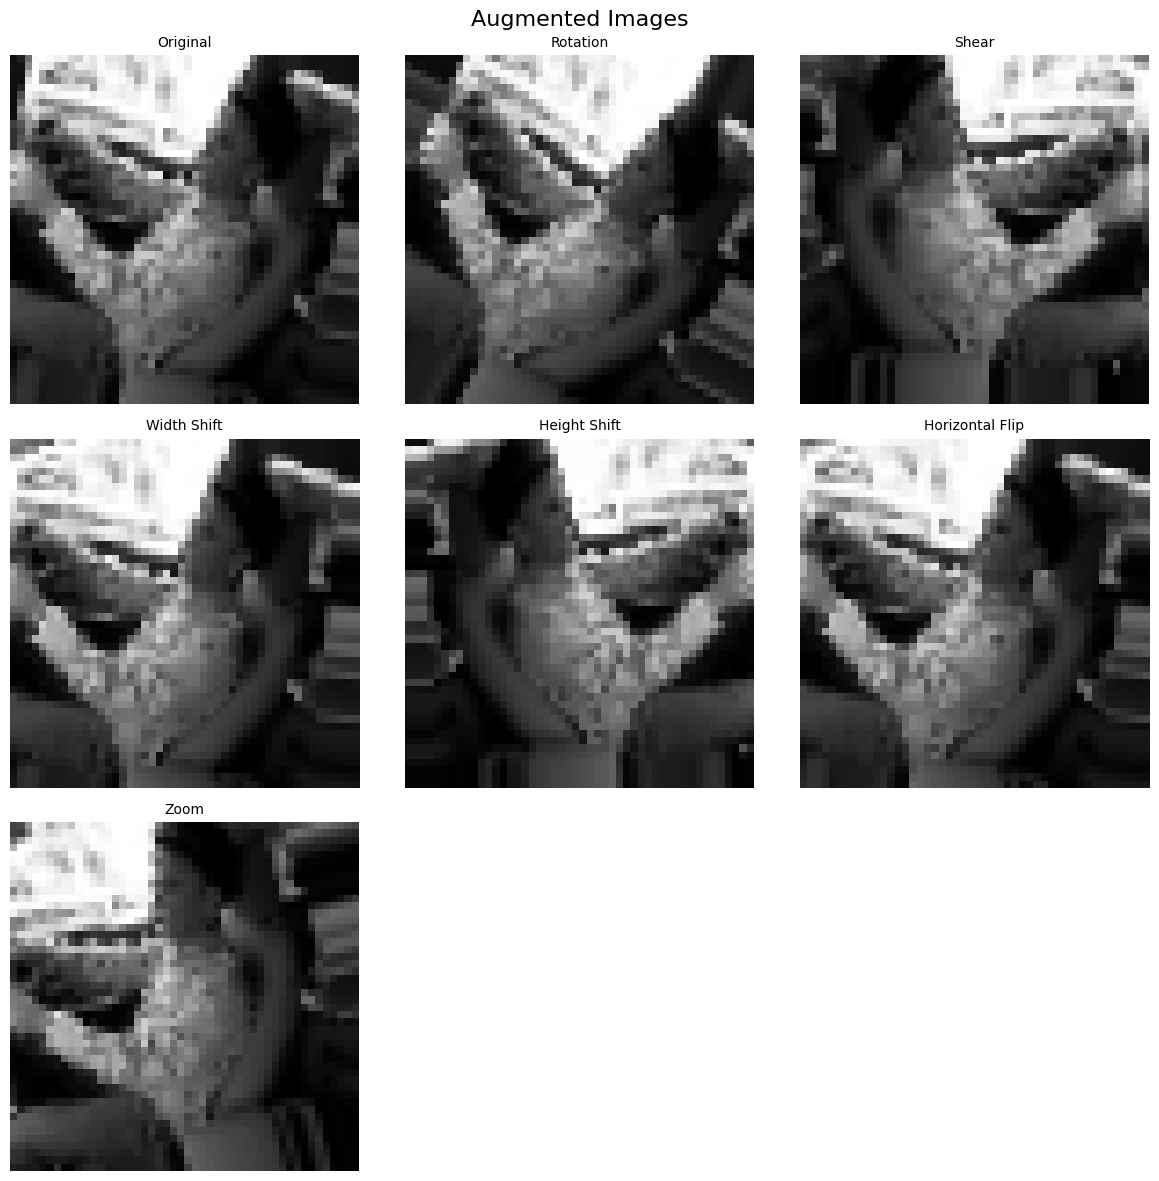

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Sample image to visualize augmentations
sample_image_path = '/content/drive/MyDrive/NEW DATASET/train/0/img_1039.jpg'  # Replace with an actual image path

# Load a sample image in grayscale mode
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

# Resize the sample image to the desired dimensions
img_size = 48  # Update with your desired image size
sample_image = cv2.resize(sample_image, (img_size, img_size))

# Create a new figure and set a title for it
fig = plt.figure(figsize=(12, 12))
fig.suptitle('Augmented Images', fontsize=16)

# Define augmentation labels
augmentation_labels = [
    'Original', 'Rotation', 'Shear', 'Width Shift',
    'Height Shift', 'Horizontal Flip', 'Zoom'
]

# Plot each augmentation separately
i = 1
for batch, label in zip(
    train_datagen.flow(
        sample_image.reshape(1, img_size, img_size, 1),
        batch_size=1
    ),
    augmentation_labels
):
    plt.subplot(3, 3, i)
    plt.imshow(batch[0].reshape(img_size, img_size), cmap='gray')  # Assuming 'grayscale' color_mode
    plt.title(label, fontsize=10)
    plt.axis('off')
    i += 1
    if i > 9:
        break  # Show 9 augmented versions

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
from keras.optimizers import Adam,SGD,RMSprop

initializer = tf.keras.initializers.HeUniform(seed=42)
reg = tf.keras.regularizers.L2(l2=0.01)
no_of_classes = 5

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same', activation='relu',input_shape = (48,48,1), kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_7 (Bat  (None, 24, 24, 128)      

Epoch :**50**

Learning Rate : 0.0001

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size
                                )

Epoch 1/50
19/46 [===========>..................] - ETA: 1:13 - loss: 4.9659 - accuracy: 0.7477

KeyboardInterrupt: 

In [ ]:
model.save('custom_modelv4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


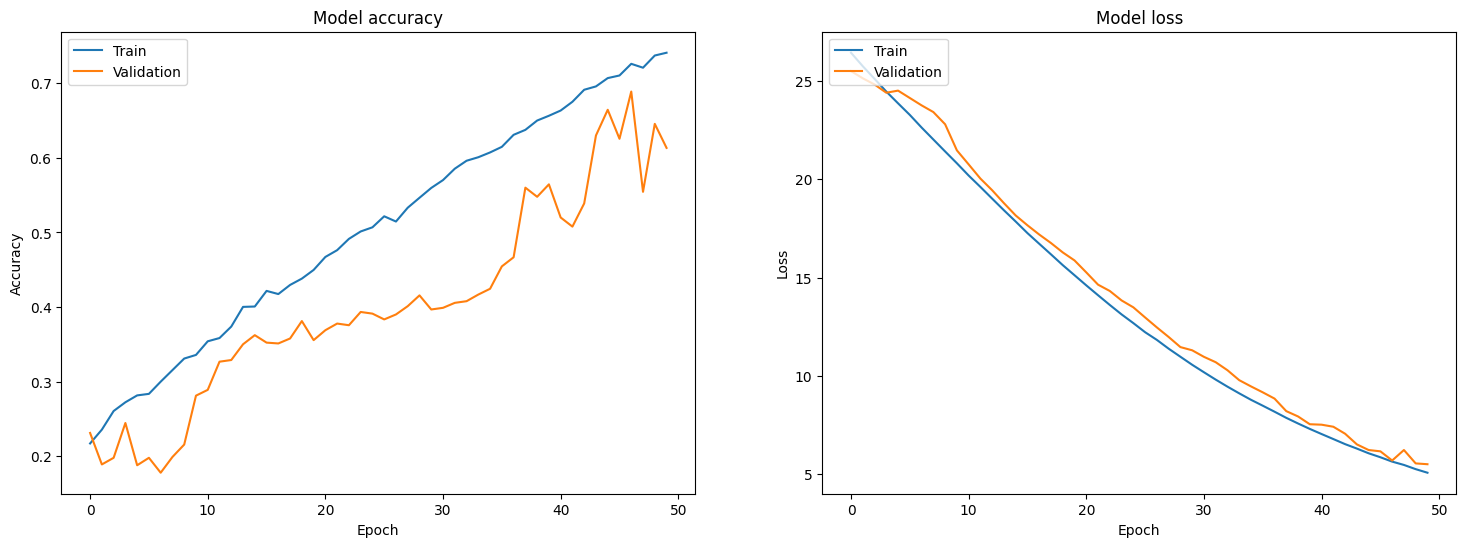

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

6/6 [==============================] - 8s 1s/step


<Figure size 640x480 with 0 Axes>

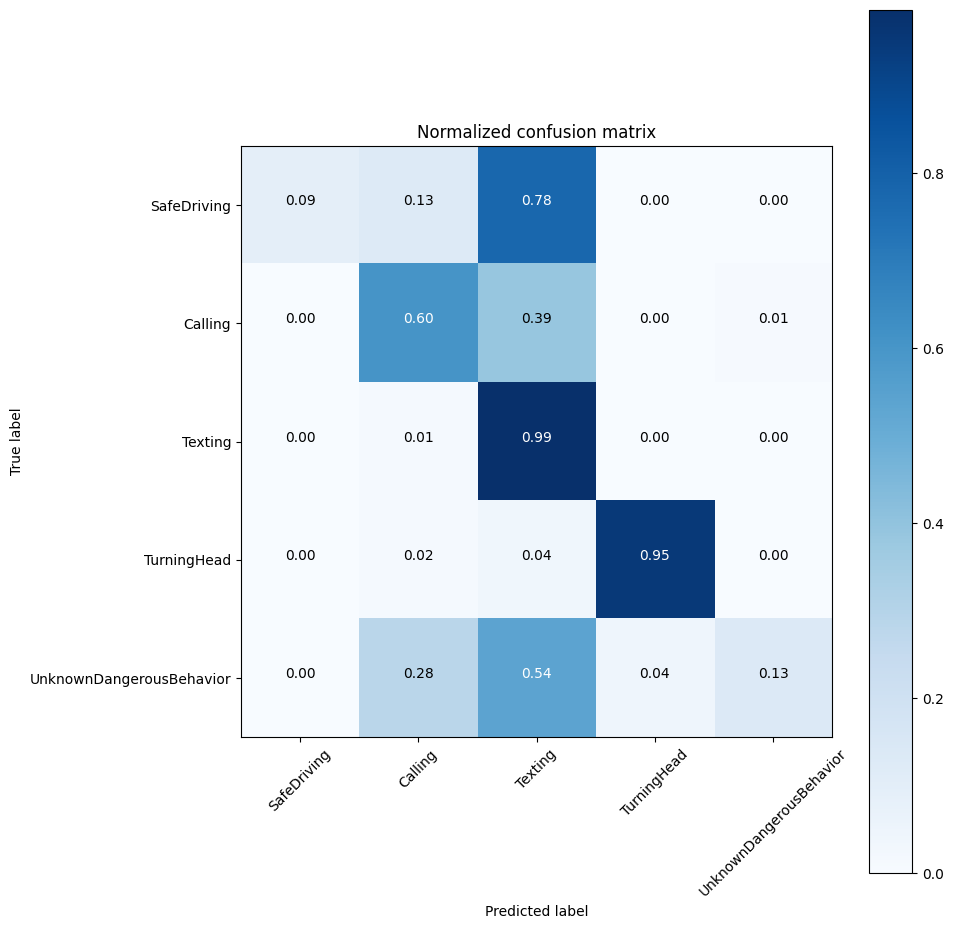

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
DB_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=DB_labels, title='Normalized confusion matrix')
plt.show()

6/6 [==============================] - 7s 1s/step


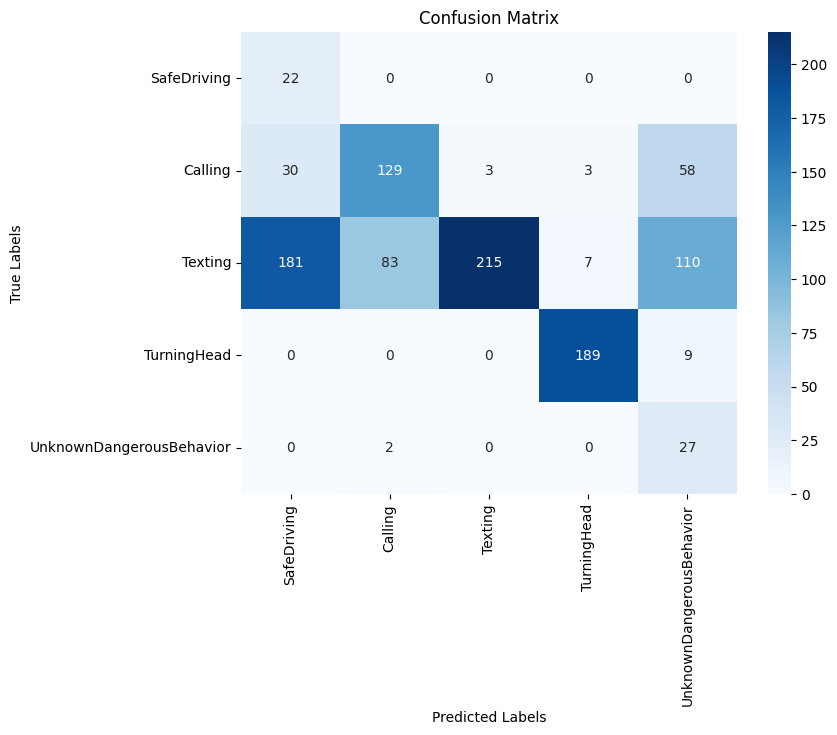

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
y_test = test_generator.classes
# Convert predictions and true labels to one-hot encoded format
test_preds_classes = test_generator.classes
test_true_classes = [np.argmax(probas) for probas in test_predictions]

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score

# Assuming you have the actual labels (y_true) and predicted labels (y_pred)
# These labels should be based on the confusion matrix from your problem

# Calculate the confusion matrix
cm = confusion_matrix(y_pred, y_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_pred, y_test)

# Calculate F1-score
f1 = f1_score(y_pred, y_test, average='micro')

# Calculate precision
precision = precision_score(y_pred, y_test, average='micro')

# Print the results
print("Confusion Matrix:")
print(cm)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))


Confusion Matrix:
[[ 22   0   0   0   0]
 [ 30 129   3   3  58]
 [181  83 215   7 110]
 [  0   0   0 189   9]
 [  0   2   0   0  27]]
Overall Accuracy: 54.49%
F1-Score: 0.54
Precision: 0.54


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, BatchNormalization,Dropout
import matplotlib.pyplot as plt
from keras import callbacks
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import seaborn as sns
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
batch_size = 16
img_size = 48

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.


In [ ]:
from keras.optimizers import Adam,SGD,RMSprop

initializer = tf.keras.initializers.HeUniform(seed=42)
reg = tf.keras.regularizers.L2(l2=0.01)
no_of_classes = 5

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same', activation='relu',input_shape = (48,48,3), kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_18 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_19 (Ba  (None, 24, 24, 128)      

Learning Rate : 0.001

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size
                                )

Epoch 1/50
527/527 [==============================] - 146s 271ms/step - loss: 15.6770 - accuracy: 0.2776 - val_loss: 16.2651 - val_accuracy: 0.2102
Epoch 2/50
527/527 [==============================] - 125s 237ms/step - loss: 4.1650 - accuracy: 0.3650 - val_loss: 3.2498 - val_accuracy: 0.3693
Epoch 3/50
527/527 [==============================] - 126s 239ms/step - loss: 3.0158 - accuracy: 0.4380 - val_loss: 2.8976 - val_accuracy: 0.4867
Epoch 4/50
527/527 [==============================] - 129s 244ms/step - loss: 2.8494 - accuracy: 0.4960 - val_loss: 3.1995 - val_accuracy: 0.4489
Epoch 5/50
527/527 [==============================] - 122s 231ms/step - loss: 2.8830 - accuracy: 0.5292 - val_loss: 2.4655 - val_accuracy: 0.6326
Epoch 6/50
527/527 [==============================] - 122s 232ms/step - loss: 2.6659 - accuracy: 0.5592 - val_loss: 2.6500 - val_accuracy: 0.5682
Epoch 7/50
527/527 [==============================] - 122s 231ms/step - loss: 2.7828 - accuracy: 0.5663 - val_loss: 2.5346

In [ ]:
model.save('custom_modelv5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


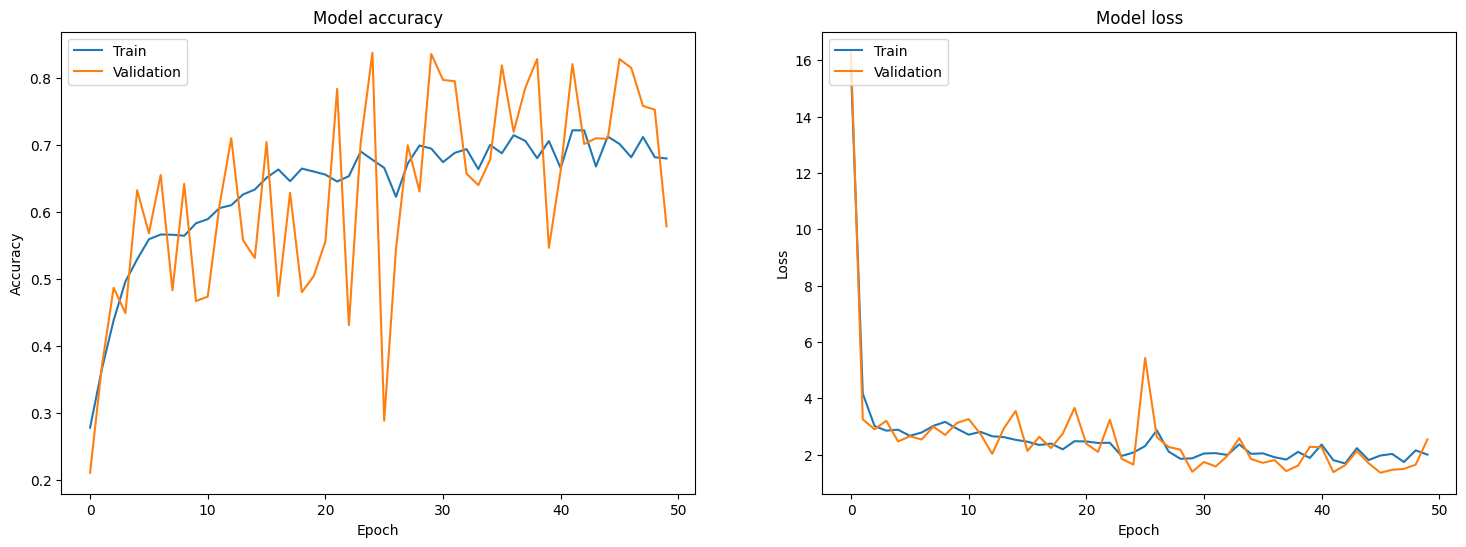

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

67/67 [==============================] - 9s 129ms/step


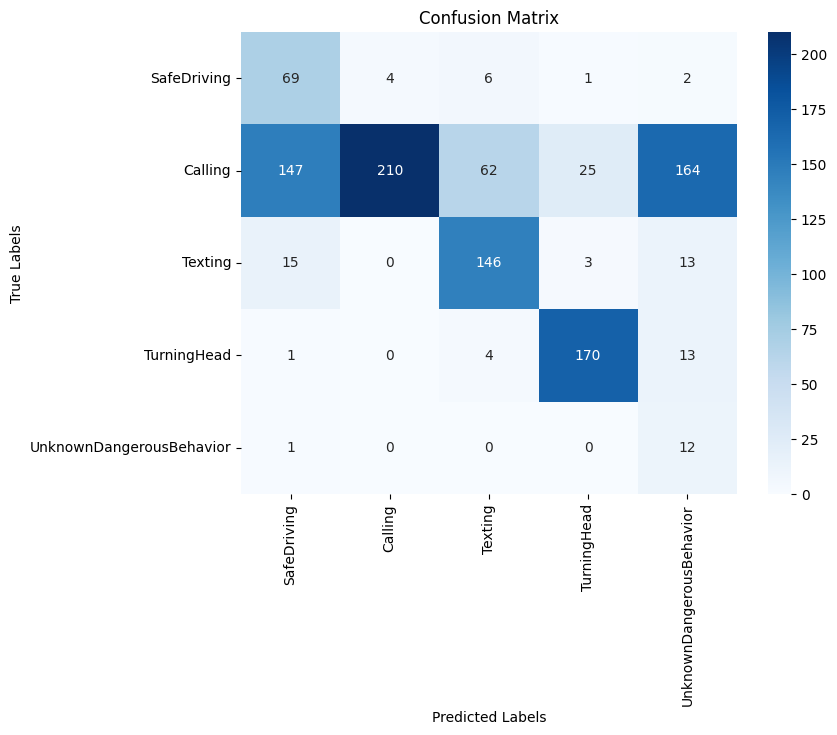

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
y_test = test_generator.classes
# Convert predictions and true labels to one-hot encoded format
test_preds_classes = test_generator.classes
test_true_classes = [np.argmax(probas) for probas in test_predictions]

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

67/67 [==============================] - 8s 115ms/step


<Figure size 640x480 with 0 Axes>

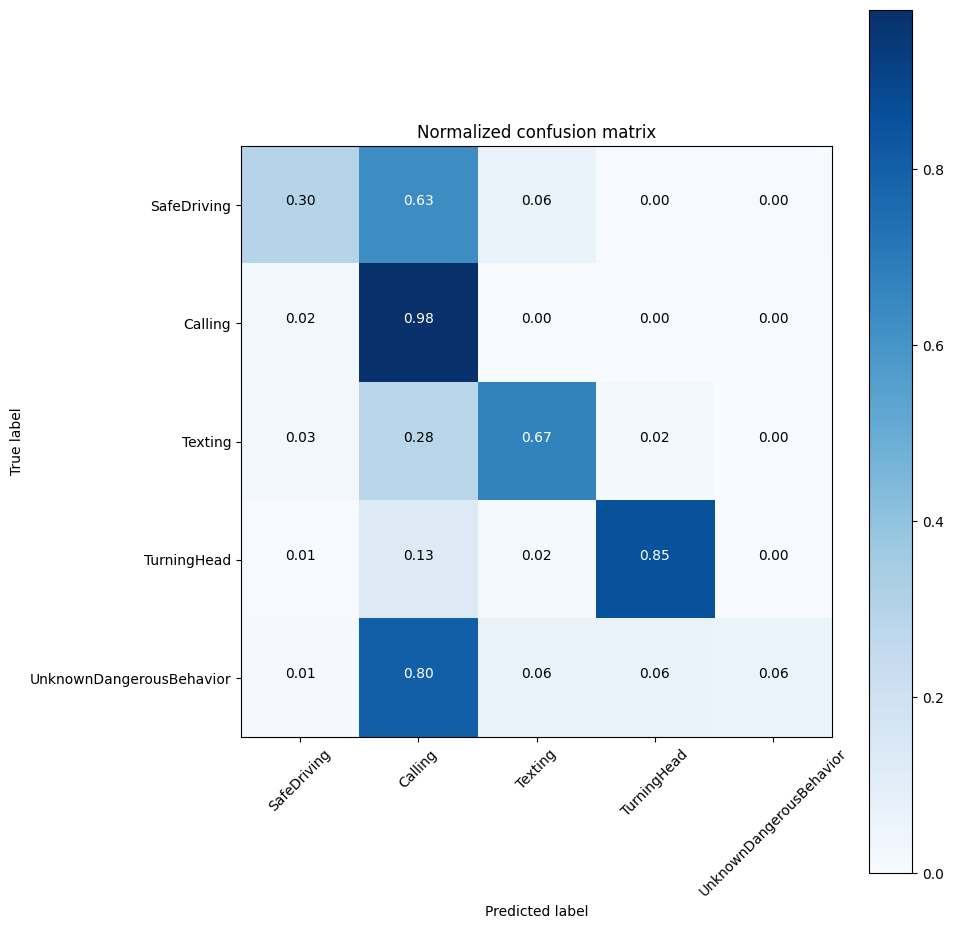

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
DB_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=DB_labels, title='Normalized confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score

# Assuming you have the actual labels (y_true) and predicted labels (y_pred)
# These labels should be based on the confusion matrix from your problem

# Calculate the confusion matrix
cm = confusion_matrix(y_pred, y_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_pred, y_test)

# Calculate F1-score
f1 = f1_score(y_pred, y_test, average='micro')

# Calculate precision
precision = precision_score(y_pred, y_test, average='micro')

# Print the results
print("Confusion Matrix:")
print(cm)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))

Confusion Matrix:
[[ 69   4   6   1   2]
 [147 210  62  25 164]
 [ 15   0 146   3  13]
 [  1   0   4 170  13]
 [  1   0   0   0  12]]
Overall Accuracy: 56.84%
F1-Score: 0.57
Precision: 0.57


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

In [ ]:
batch_size = 64
img_size = 48

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.


In [ ]:
model = Sequential()

#module 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48,48,3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

#module 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

#module 3
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#fully connected layer
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_24 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_25 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)       

In [ ]:
epochs = 50

steps_per_epoch = train_generator.n // train_generator.batch_size

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator)

Epoch 1/50
131/131 [==============================] - 134s 994ms/step - loss: 1.4546 - accuracy: 0.4075 - val_loss: 2.4430 - val_accuracy: 0.1910
Epoch 2/50
131/131 [==============================] - 127s 964ms/step - loss: 0.9261 - accuracy: 0.6331 - val_loss: 3.4028 - val_accuracy: 0.2191
Epoch 3/50
131/131 [==============================] - 126s 963ms/step - loss: 0.6073 - accuracy: 0.7739 - val_loss: 1.9456 - val_accuracy: 0.3933
Epoch 4/50
131/131 [==============================] - 127s 967ms/step - loss: 0.4641 - accuracy: 0.8324 - val_loss: 1.3124 - val_accuracy: 0.6348
Epoch 5/50
131/131 [==============================] - 126s 963ms/step - loss: 0.3883 - accuracy: 0.8658 - val_loss: 2.1316 - val_accuracy: 0.6152
Epoch 6/50
131/131 [==============================] - 126s 957ms/step - loss: 0.2892 - accuracy: 0.8994 - val_loss: 0.9410 - val_accuracy: 0.7556
Epoch 7/50
131/131 [==============================] - 125s 953ms/step - loss: 0.2723 - accuracy: 0.9048 - val_loss: 0.3962 -

In [ ]:
model.save('custom_modelv7.h5')

NameError: name 'model' is not defined

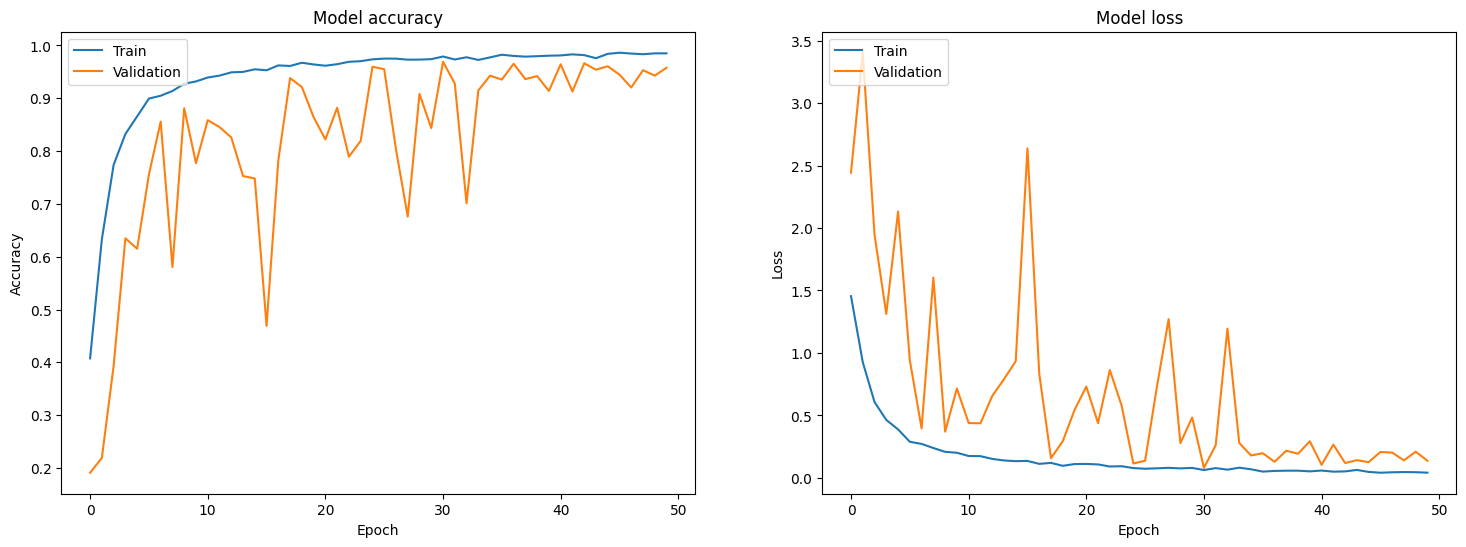

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

17/17 [==============================] - 8s 469ms/step


<Figure size 640x480 with 0 Axes>

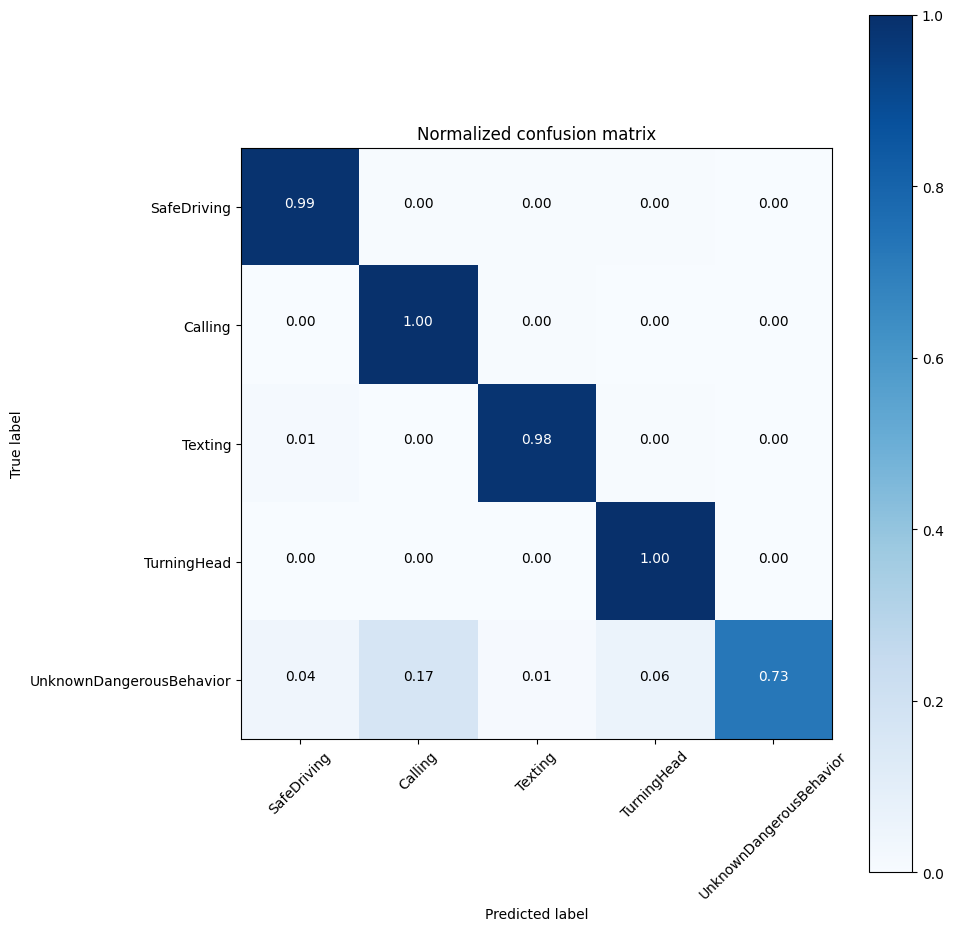

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
emotion_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=emotion_labels, title='Normalized confusion matrix')
plt.show()

17/17 [==============================] - 8s 454ms/step


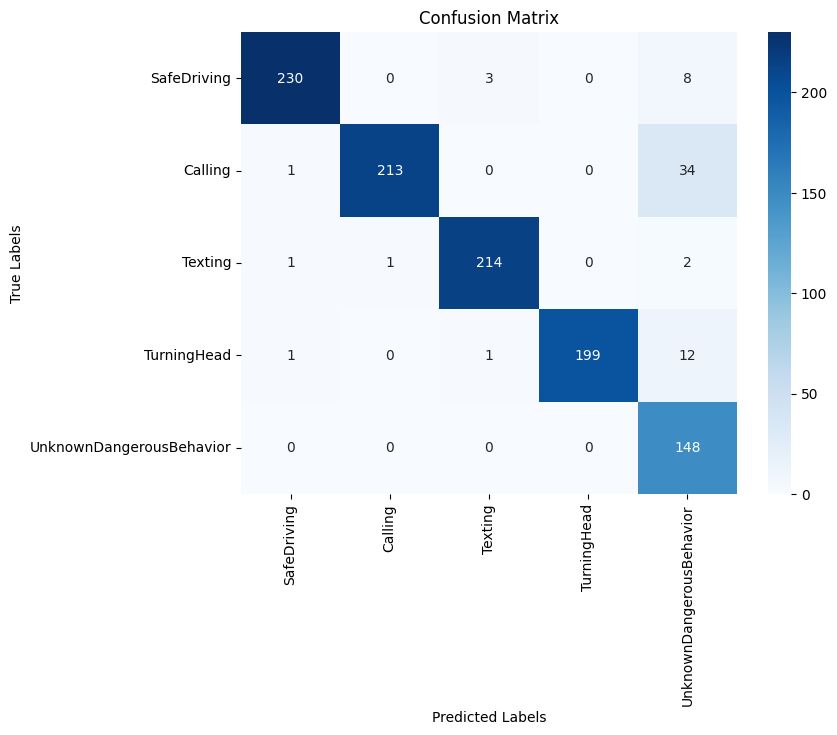

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
y_test = test_generator.classes
# Convert predictions and true labels to one-hot encoded format
test_preds_classes = test_generator.classes
test_true_classes = [np.argmax(probas) for probas in test_predictions]

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score

# Assuming you have the actual labels (y_true) and predicted labels (y_pred)
# These labels should be based on the confusion matrix from your problem

# Calculate the confusion matrix
cm = confusion_matrix(y_pred, y_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_pred, y_test)

# Calculate F1-score
f1 = f1_score(y_pred, y_test, average='micro')

# Calculate precision
precision = precision_score(y_pred, y_test, average='micro')

# Print the results
print("Confusion Matrix:")
print(cm)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))

Confusion Matrix:
[[230   0   3   0   8]
 [  1 213   0   0  34]
 [  1   1 214   0   2]
 [  1   0   1 199  12]
 [  0   0   0   0 148]]
Overall Accuracy: 94.01%
F1-Score: 0.94
Precision: 0.94


BS:8 , LR: 0.01 EPOCH **50**

In [ ]:
batch_size = 8  # Updated batch size
img_size = 48
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.losses import categorical_crossentropy  # Importing categorical_crossentropy

model = Sequential()

# Module 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

# Module 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

# Module 3
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

# Flatten
model.add(Flatten())

# Dense 1
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Dense 2
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Fully connected layer
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01),  # Updated learning rate
              loss=categorical_crossentropy,
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_21 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_14 (Activation)  (None, 46, 46, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_22 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 46, 46, 64)       

In [ ]:
epochs = 50

steps_per_epoch = train_generator.n // train_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/50
 256/1054 [======>.......................] - ETA: 55s - loss: 0.1379 - accuracy: 0.9609

KeyboardInterrupt: 

In [ ]:
model.save('custom_modelv7.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


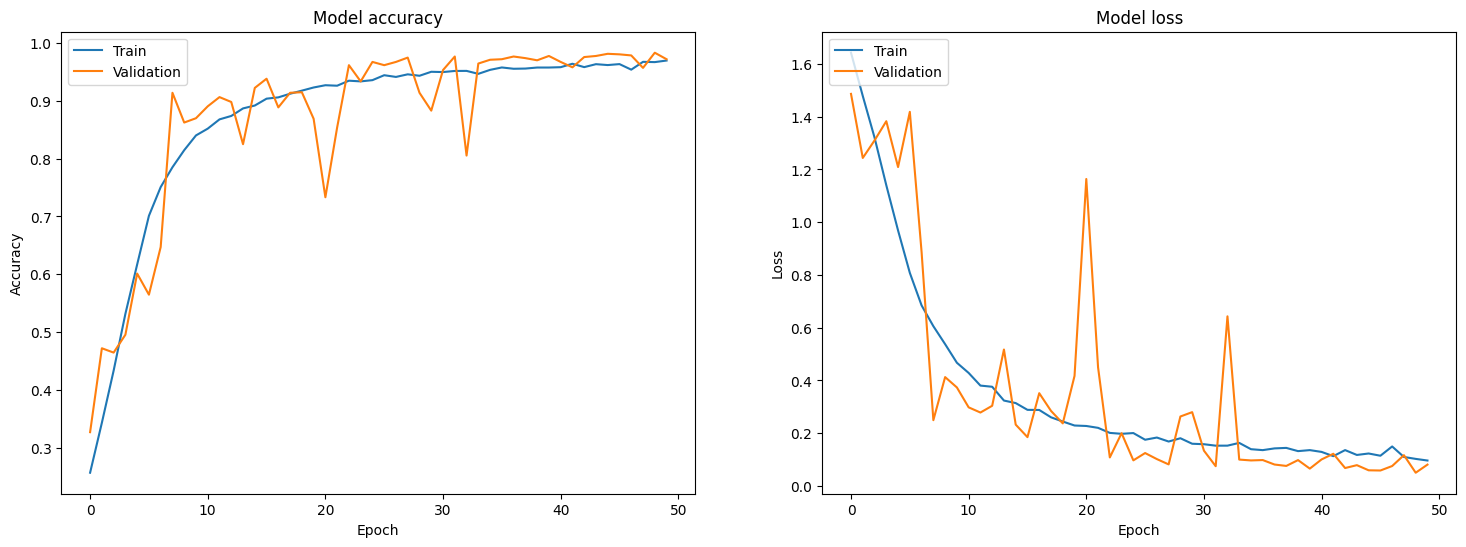

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
import seaborn as sns


134/134 [==============================] - 5s 39ms/step


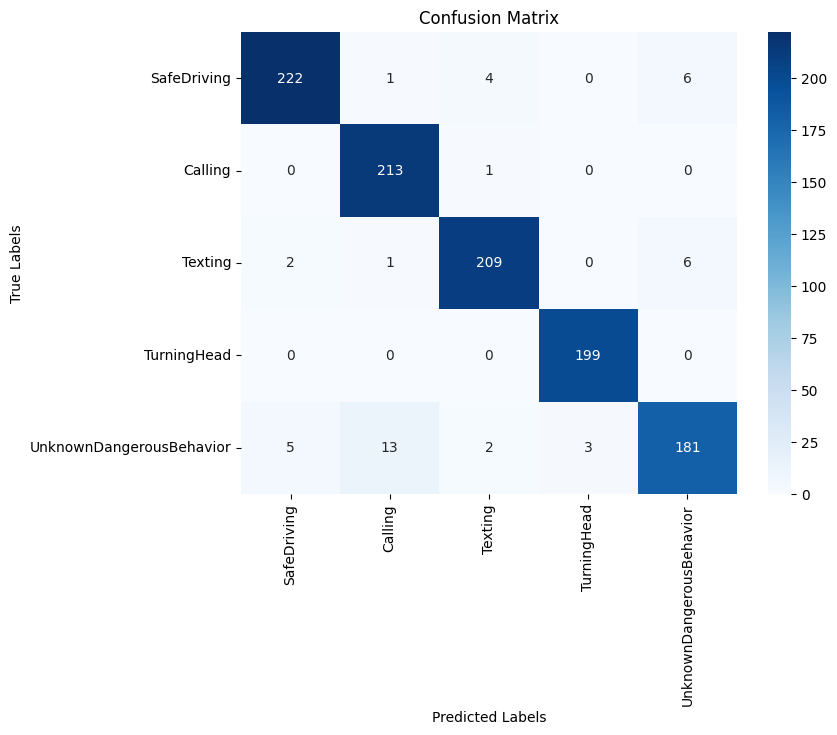

Overall Accuracy: 95.88%
F1-Score: 0.96
Precision: 0.96


In [ ]:
# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
y_test = test_generator.classes

# Convert predictions and true labels to one-hot encoded format
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Define the class labels
class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import accuracy_score, f1_score, precision_score

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))


LB 8 LR 0.001 EPOCH **50**

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy

batch_size = 8
learning_rate = 0.001
epochs = 50

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

model = Sequential()

# Module 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

# Module 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

# Module 3
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())

# Flatten
model.add(Flatten())

# Dense 1
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Dense 2
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Fully connected layer
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // validation_generator.batch_size
)


Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_29 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_22 (Activation)  (None, 46, 46, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_30 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


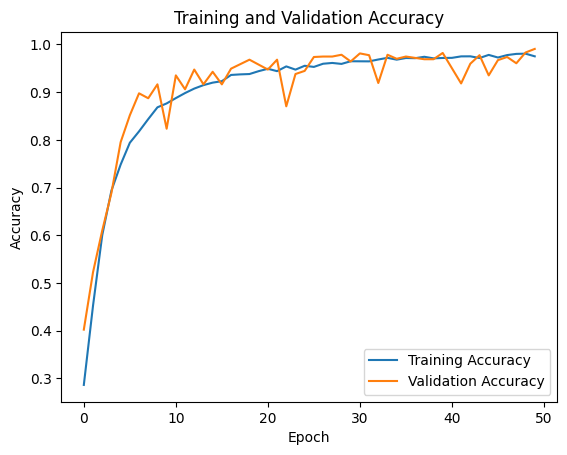

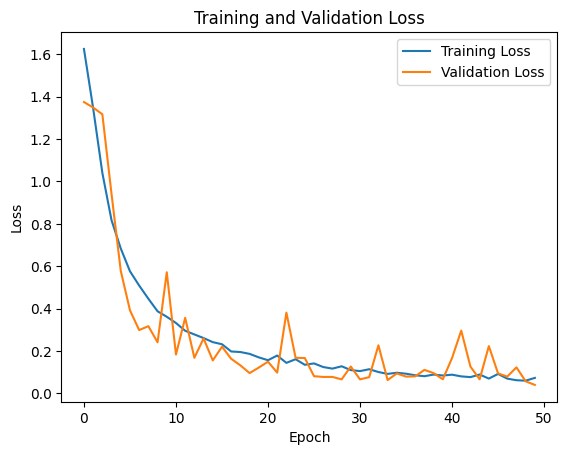

134/134 [==============================] - 5s 39ms/step


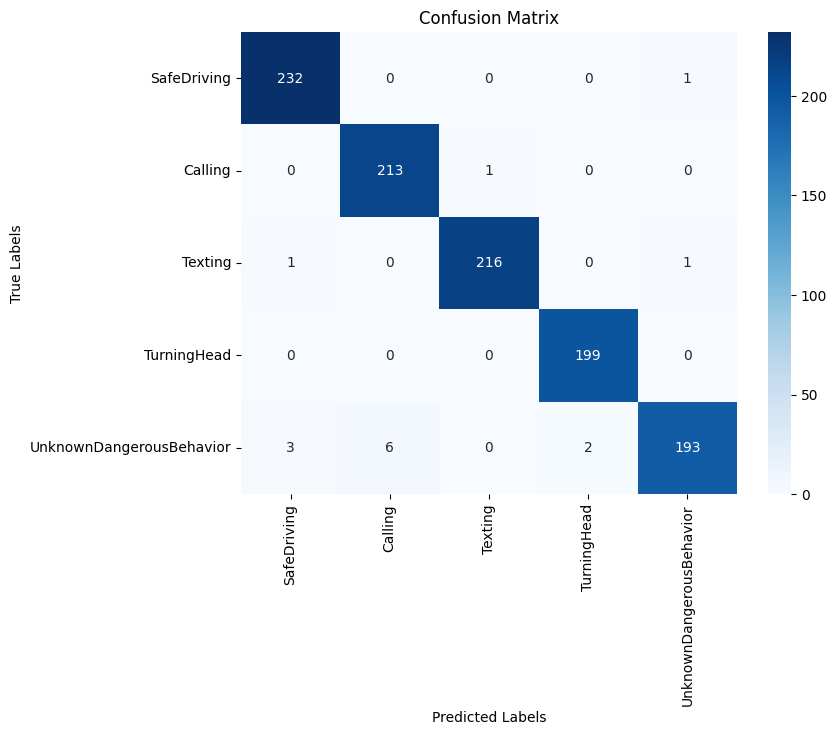

Overall Accuracy: 98.60%
F1-Score: 0.99
Precision: 0.99


In [ ]:
# Save the model
model.save('custom_model_batch8_lr0.001_epoch50.h5')

# Plot the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))

50 **8** 0.0001 *

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
epochs = 50

# Change batch size
batch_size = 8

# Change learning rate
learning_rate = 0.0001

# Re-compile the model with the updated parameters
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

# Save the model
model.save('custom_model_batch8_lr0.0001_epoch50.h5')



Epoch 1/50


KeyboardInterrupt: 

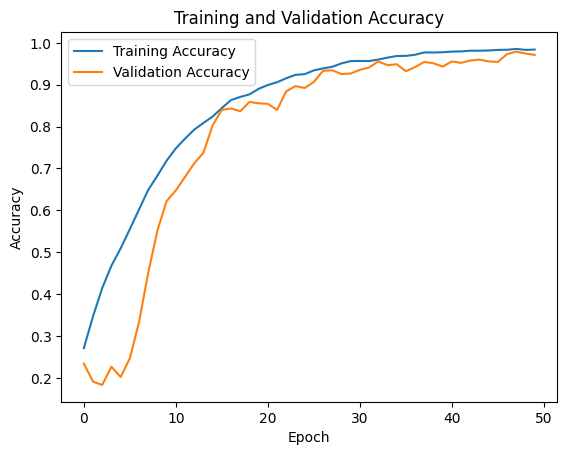

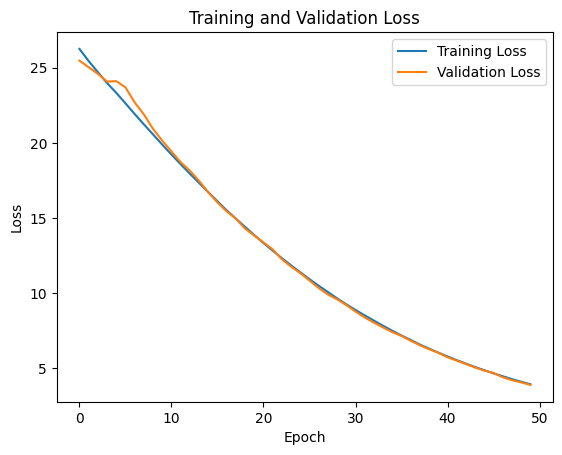

6/6 [==============================] - 23s 3s/step


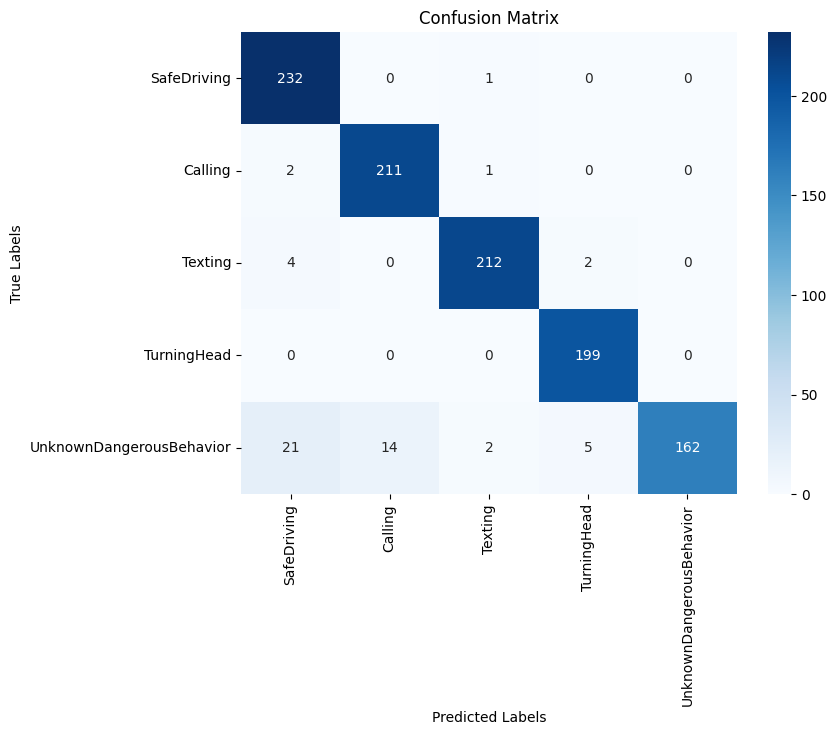

Overall Accuracy: 95.13%
F1-Score: 0.95
Precision: 0.95


In [ ]:
import seaborn as sns
class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

# Plot the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))


16 , 0.01, 0.001, 0.001 EPOCH **50**

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

# Update batch size
batch_size = 16
img_size = 48

# Define learning rate
learning_rate = 0.01

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
epochs = 50
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size)

# Save the model
model.save('custom_model_lr_0_01_batch_16_epoch_50.h5')
model.save('/content/drive/MyDrive/custom_model_lr_0_001_batch_64_epoch_50.h5')


Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


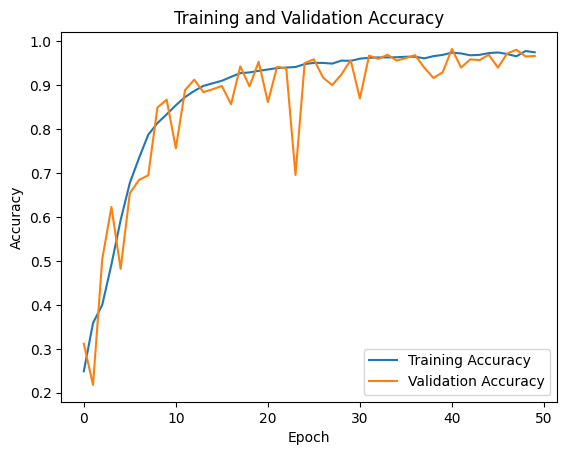

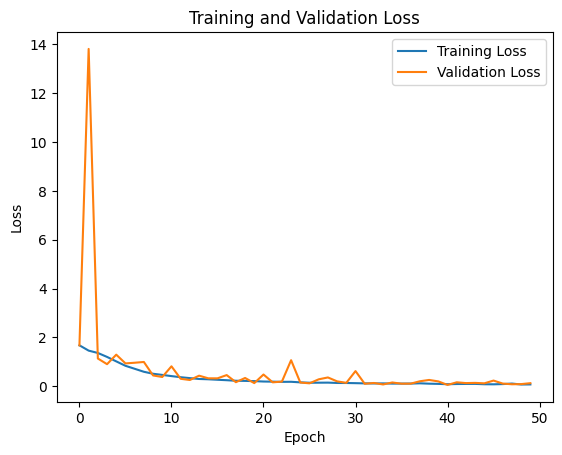

67/67 [==============================] - 4s 60ms/step


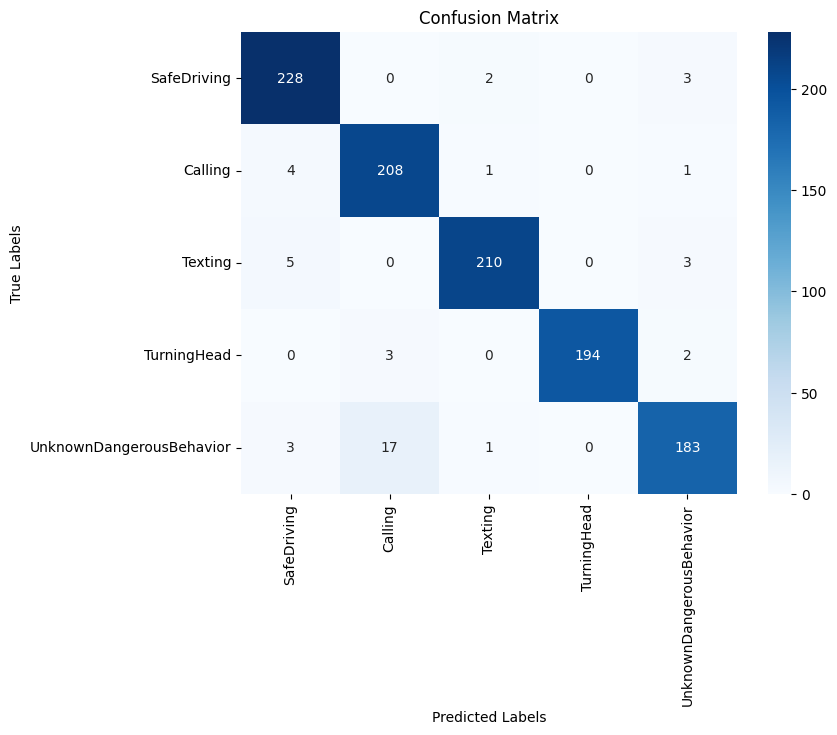

Overall Accuracy: 95.79%
F1-Score: 0.96
Precision: 0.96


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
import seaborn as sns

# Plot training history (assuming `history` variable is defined)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))


16 0.001

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

# Update batch size
batch_size = 16
img_size = 48

# Define learning rate
learning_rate = 0.001

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
epochs = 50
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size)

# Save the model
model.save('custom_model_lr_0_001_batch_16_epoch_50.h5')
model.save('/content/drive/MyDrive/custom_model_lr_0_001_batch_16_epoch_50.h5')



Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_8 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 46, 46, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_9 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


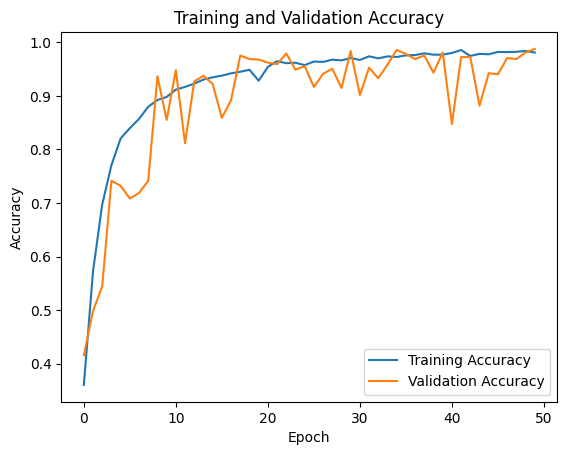

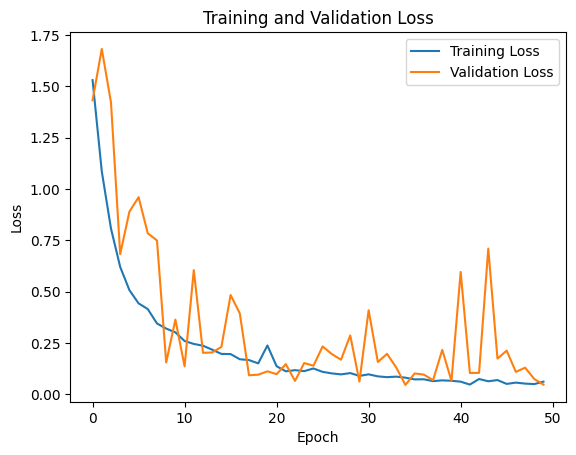

67/67 [==============================] - 4s 55ms/step


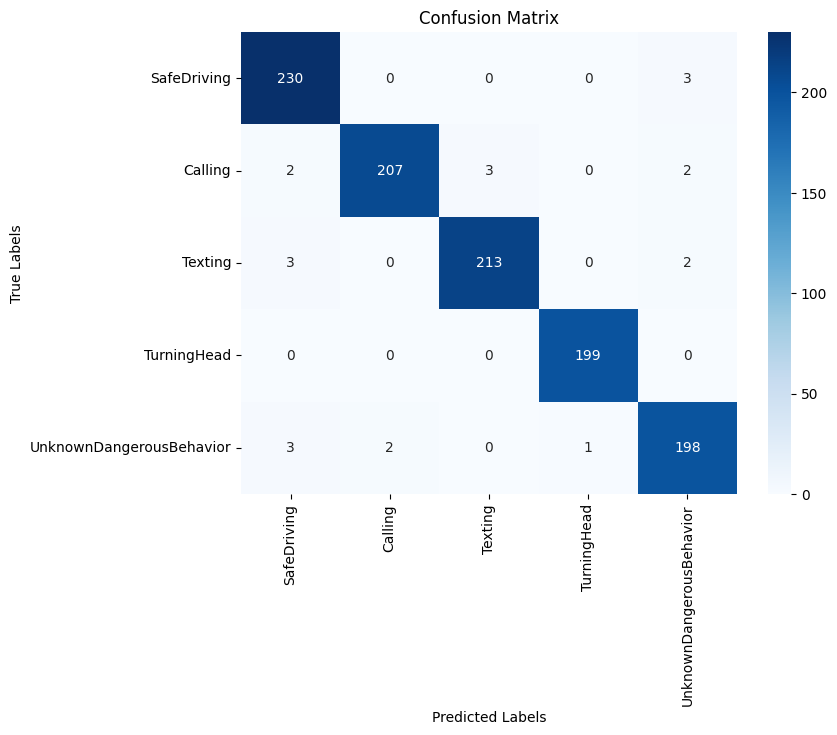

Overall Accuracy: 98.03%
F1-Score: 0.98
Precision: 0.98


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
import seaborn as sns

# Plot training history (assuming `history` variable is defined)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("F1-Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

# Update batch size
batch_size = 16
img_size = 48

# Define learning rate
learning_rate = 0.0001

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
epochs = 50
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size)

# Save the model
model.save('custom_model_lr_0_0001_batch_16_epoch_50.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Learning Rate 0.0001)')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Learning Rate 0.0001)')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Learning Rate 0.0001)')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy (Learning Rate 0.0001): {:.2f}%".format(accuracy * 100))
print("F1-Score (Learning Rate 0.0001): {:.2f}".format(f1))
print("Precision (Learning Rate 0.0001): {:.2f}".format(precision))



32 0.01 0.001 **0.0001**

Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


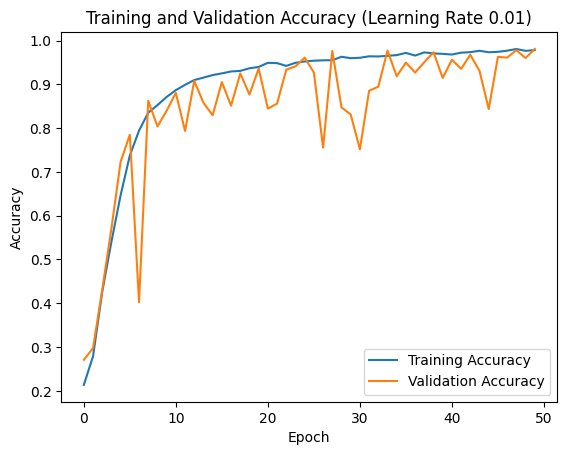

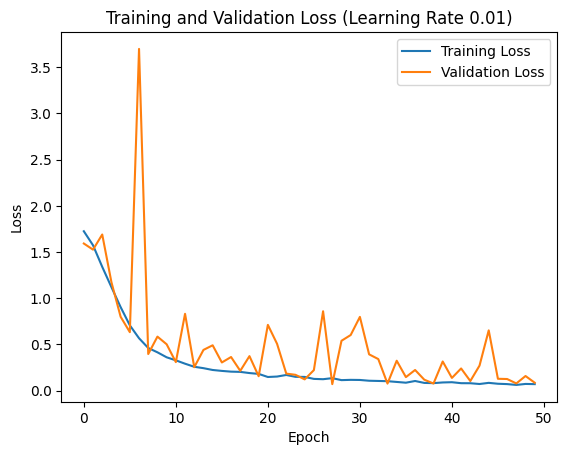

34/34 [==============================] - 263s 8s/step


NameError: name 'class_labels' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

# Update batch size
batch_size = 32
img_size = 48

# Define learning rate
learning_rate = 0.01

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
epochs = 50
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size)

# Save the model
model.save('custom_model_lr_0_01_batch_32_epoch_50.h5')
model.save('/content/drive/MyDrive/custom_model_lr_0_01_batch_32_epoch_50.h5')

import seaborn as sns
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score

class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Learning Rate 0.01)')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Learning Rate 0.01)')
plt.show()

class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Learning Rate 0.01)')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy (Learning Rate 0.01): {:.2f}%".format(accuracy * 100))
print("F1-Score (Learning Rate 0.01): {:.2f}".format(f1))
print("Precision (Learning Rate 0.01): {:.2f}".format(precision))


34/34 [==============================] - 8s 244ms/step


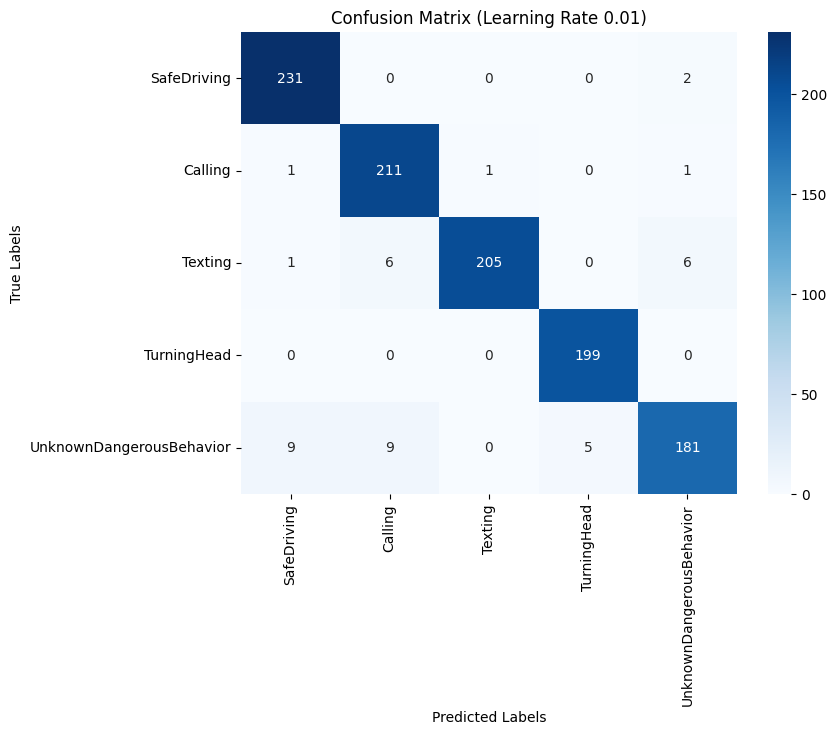

Overall Accuracy (Learning Rate 0.01): 96.16%
F1-Score (Learning Rate 0.01): 0.96
Precision (Learning Rate 0.01): 0.96


In [ ]:
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score
class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']
# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Learning Rate 0.01)')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy (Learning Rate 0.01): {:.2f}%".format(accuracy * 100))
print("F1-Score (Learning Rate 0.01): {:.2f}".format(f1))
print("Precision (Learning Rate 0.01): {:.2f}".format(precision))


Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_8 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 46, 46, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_9 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


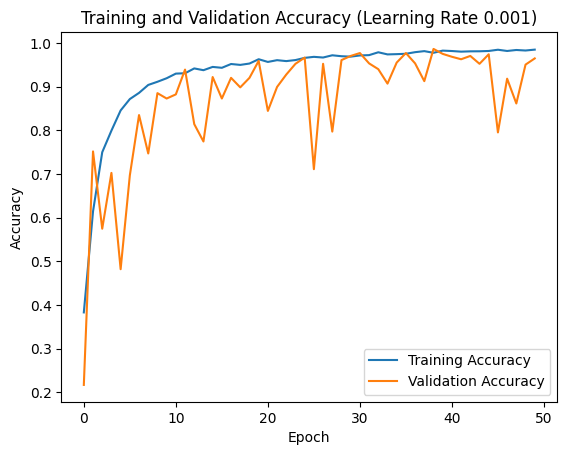

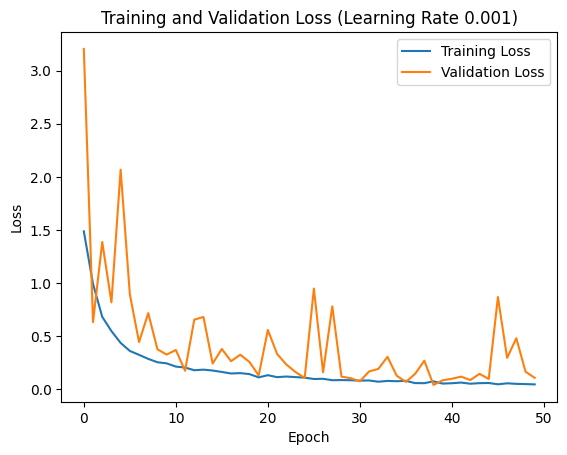

34/34 [==============================] - 7s 208ms/step


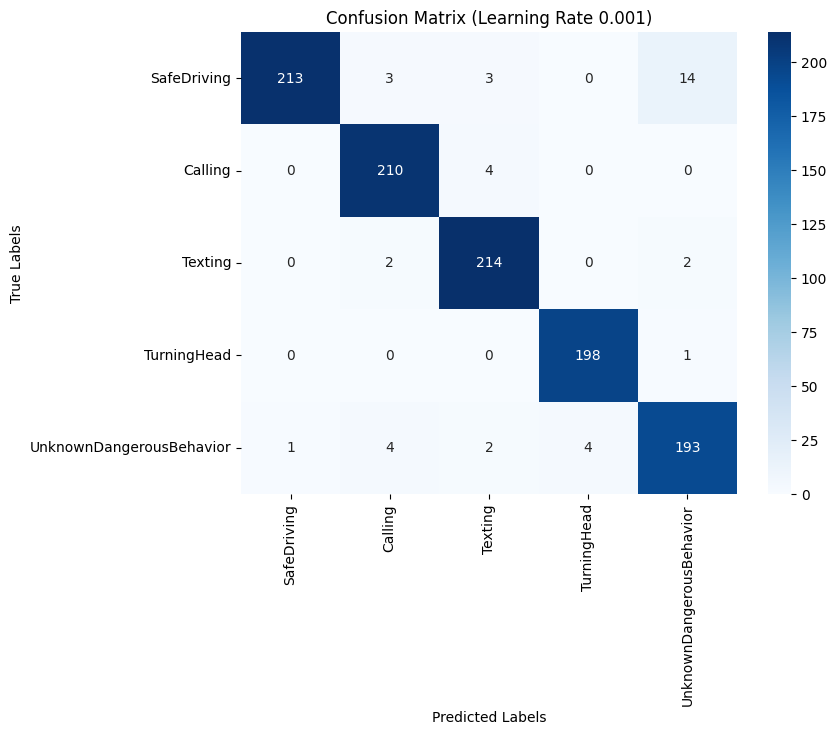

Overall Accuracy (Learning Rate 0.001): 96.25%
F1-Score (Learning Rate 0.001): 0.96
Precision (Learning Rate 0.001): 0.96


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

# Update batch size
batch_size = 32
img_size = 48

# Define learning rate
learning_rate = 0.001

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
epochs = 50
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size)

# Save the model
model.save('custom_model_lr_0_001_batch_32_epoch_50.h5')
model.save('/content/drive/MyDrive/custom_model_lr_0_001_batch_32_epoch_50.h5')

import seaborn as sns
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score
class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Learning Rate 0.001)')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Learning Rate 0.001)')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Learning Rate 0.001)')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy (Learning Rate 0.001): {:.2f}%".format(accuracy * 100))
print("F1-Score (Learning Rate 0.001): {:.2f}".format(f1))
print("Precision (Learning Rate 0.001): {:.2f}".format(precision))


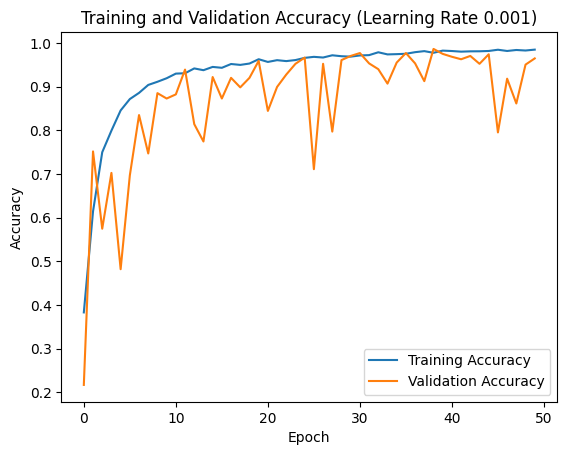

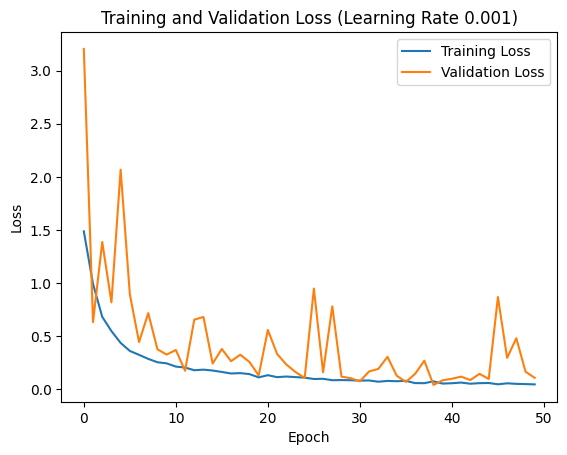

34/34 [==============================] - 7s 217ms/step


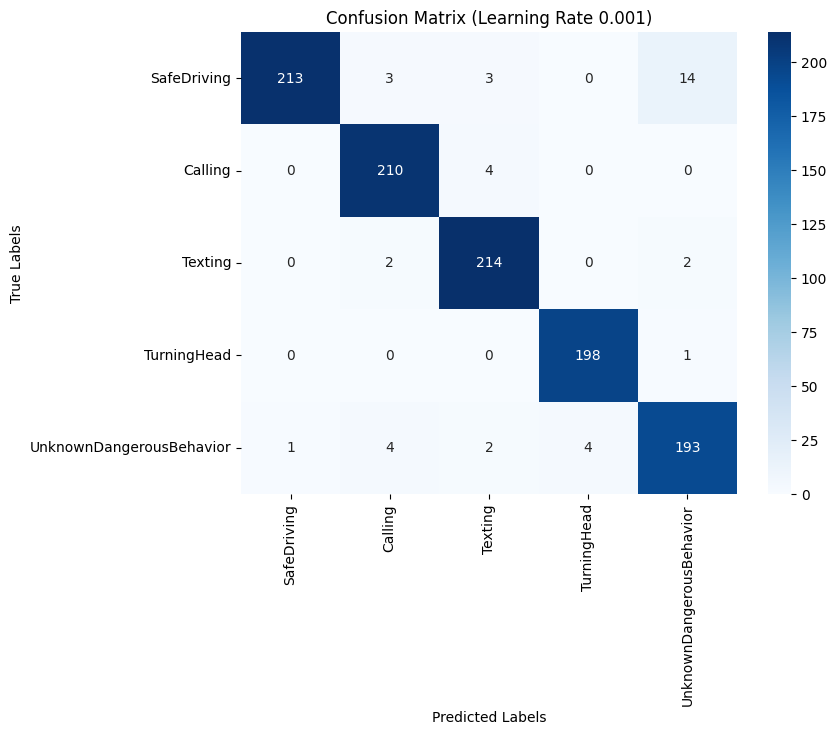

Overall Accuracy (Learning Rate 0.001): 96.25%
F1-Score (Learning Rate 0.001): 0.96
Precision (Learning Rate 0.001): 0.96


In [ ]:
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score
class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Learning Rate 0.001)')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Learning Rate 0.001)')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Learning Rate 0.001)')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy (Learning Rate 0.001): {:.2f}%".format(accuracy * 100))
print("F1-Score (Learning Rate 0.001): {:.2f}".format(f1))
print("Precision (Learning Rate 0.001): {:.2f}".format(precision))


Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_16 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 46, 46, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_17 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


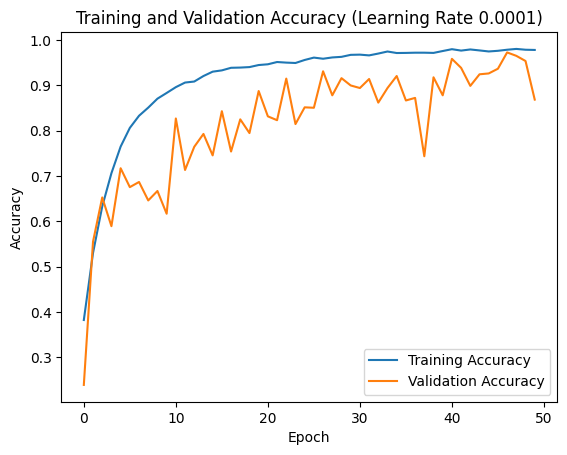

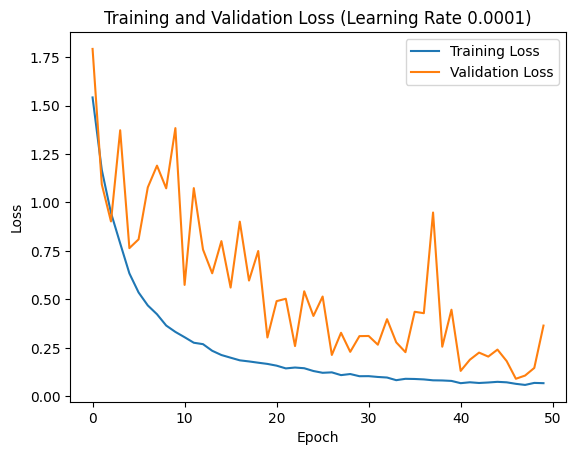

34/34 [==============================] - 9s 244ms/step


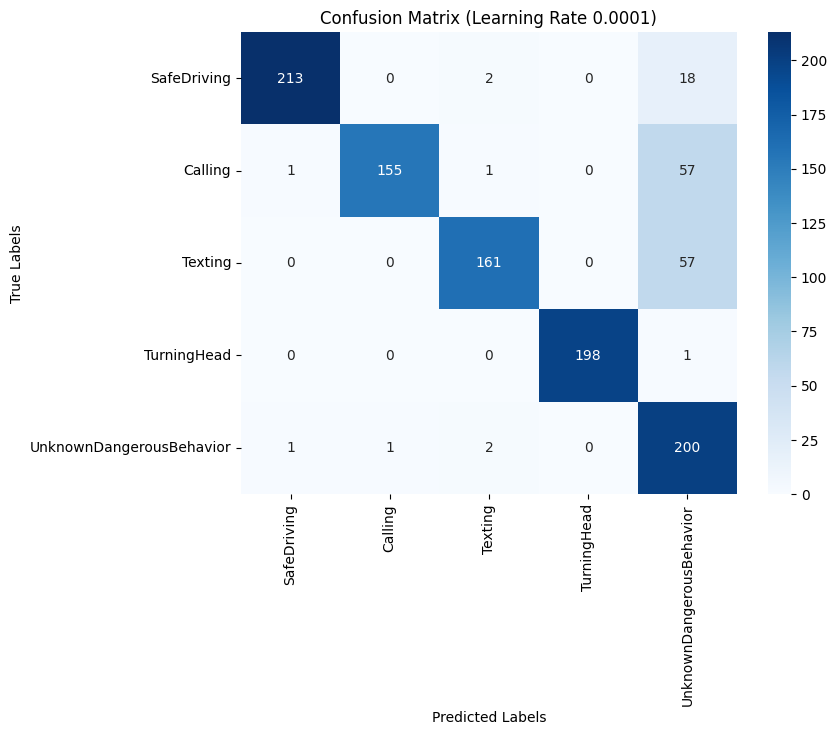

Overall Accuracy (Learning Rate 0.0001): 86.80%
F1-Score (Learning Rate 0.0001): 0.87
Precision (Learning Rate 0.0001): 0.87


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score
class_labels = ['SafeDriving', 'Calling', 'Texting', 'TurningHead', 'UnknownDangerousBehavior']


from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

# Update batch size
batch_size = 32
img_size = 48

# Define learning rate
learning_rate = 0.0001

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
epochs = 50
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size)

# Save the model
model.save('custom_model_lr_0_0001_batch_32_epoch_50.h5')
model.save('/content/drive/MyDrive/custom_model_lr_0_0001_batch_32_epoch_50.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Learning Rate 0.0001)')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Learning Rate 0.0001)')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Learning Rate 0.0001)')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy (Learning Rate 0.0001): {:.2f}%".format(accuracy * 100))
print("F1-Score (Learning Rate 0.0001): {:.2f}".format(f1))
print("Precision (Learning Rate 0.0001): {:.2f}".format(precision))


64 50 0.01 0.001 **0.0001**

In [ ]:
# Update batch size
batch_size = 64

# Define learning rate
learning_rate = 0.01

# Model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size)

# Save the model
model.save('custom_model_lr_0_01_batch_64_epoch_50.h5')
model.save('/content/drive/MyDrive/custom_model_lr_0_01_batch_64_epoch_50.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_24 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 46, 46, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_25 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_25 (Activation)  (None, 46, 46, 64)       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


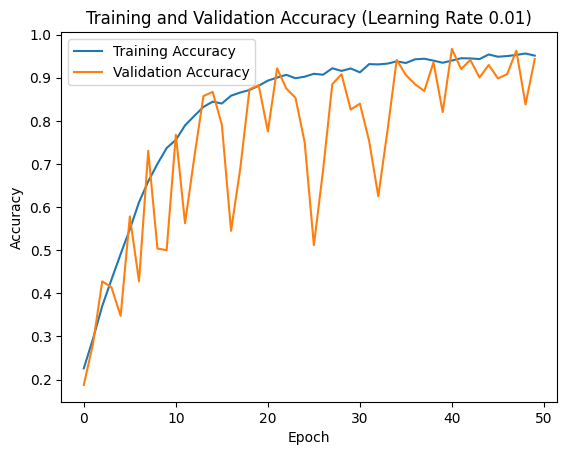

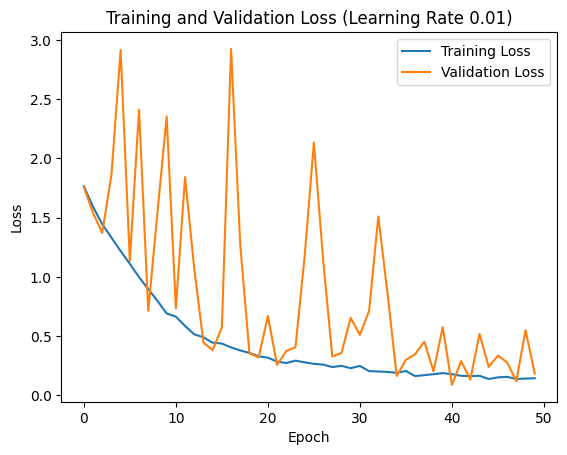

34/34 [==============================] - 8s 240ms/step


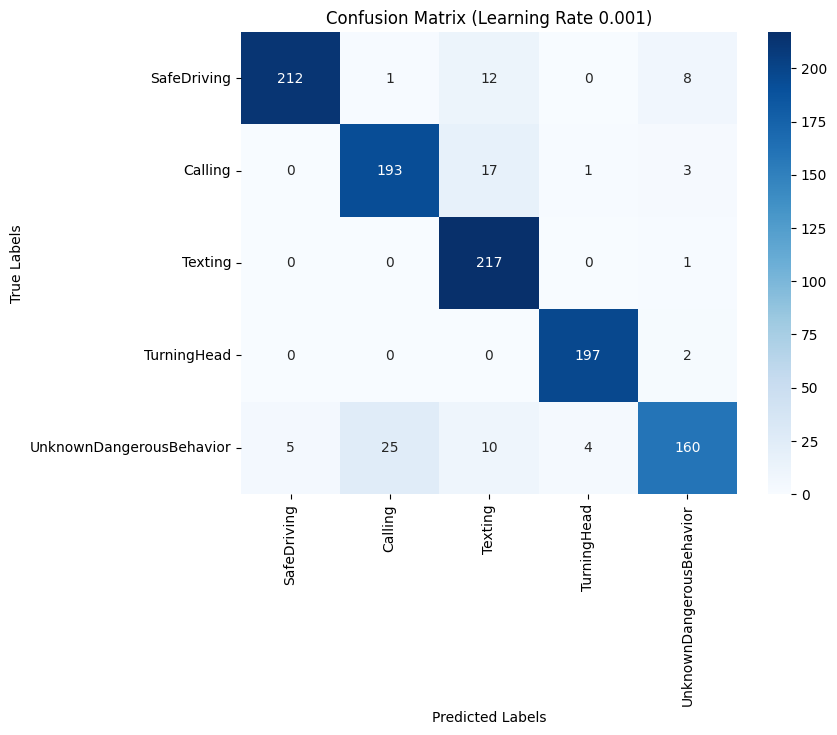

Overall Accuracy (Learning Rate 0.001): 91.67%
F1-Score (Learning Rate 0.01): 0.92
Precision (Learning Rate 0.01): 0.92


In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Learning Rate 0.01)')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Learning Rate 0.01)')
plt.show()

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [np.argmax(probas) for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Learning Rate 0.001)')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)

# Calculate F1-score
f1 = f1_score(test_true_classes, test_preds_classes, average='micro')

# Calculate precision
precision = precision_score(test_true_classes, test_preds_classes, average='micro')

# Print the results
print("Overall Accuracy (Learning Rate 0.01): {:.2f}%".format(accuracy * 100))
print("F1-Score (Learning Rate 0.01): {:.2f}".format(f1))
print("Precision (Learning Rate 0.01): {:.2f}".format(precision))


**64 0.001 50**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set the training parameters
batch_size = 64
learning_rate = 0.001
epochs = 50

# Load the dataset using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the model architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [tf.argmax(probas).numpy() for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))

# Generate classification report
report = classification_report(test_true_classes, test_preds_classes, target_names=test_generator.class_indices)
print(report)

# Calculate and print F1-score, precision, and recall for each class
f1_scores = f1_score(test_true_classes, test_preds_classes, average=None)
precisions = precision_score(test_true_classes, test_preds_classes, average=None)
recalls = recall_score(test_true_classes, test_preds_classes, average=None)
for i, label in enumerate(test_generator.class_indices):
    print(f"\nClass: {label}")
    print(f"F1-Score: {f1_scores[i]:.2f}")
    print(f"Precision: {precisions[i]:.2f}")
    print(f"Recall: {recalls[i]:.2f}")


64 0.0001 50

Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Epoch 1/50
131/131 [==============================] - 2915s 22s/step - loss: 0.6660 - accuracy: 0.7591 - val_loss: 1.6423 - val_accuracy: 0.2070
Epoch 2/50
131/131 [==============================] - 32s 247ms/step - loss: 0.0658 - accuracy: 0.9866 - val_loss: 1.6794 - val_accuracy: 0.2812
Epoch 3/50
131/131 [==============================] - 33s 249ms/step - loss: 0.0091 - accuracy: 0.9999 - val_loss: 1.5614 - val_accuracy: 0.4072
Epoch 4/50
131/131 [==============================] - 33s 249ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.5467 - val_accuracy: 0.7812
Epoch 5/50
131/131 [==============================] - 33s 250ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1151 - val_accuracy: 0.9678
Epoch 6/50
131/131 [==============================] - 32s 240ms/step - loss: 9.7651e-04 - accuracy: 1.0000 - val_loss: 0.0745 - val_accuracy: 0.9736


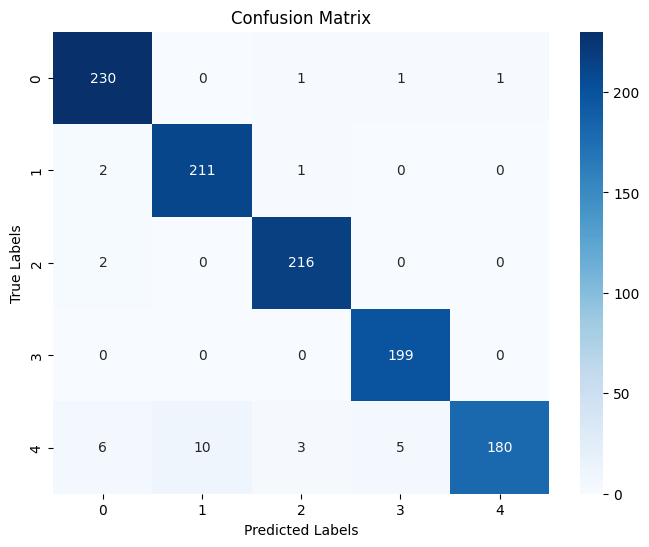

Overall Accuracy: 97.00%
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       233
           1       0.95      0.99      0.97       214
           2       0.98      0.99      0.98       218
           3       0.97      1.00      0.99       199
           4       0.99      0.88      0.94       204

    accuracy                           0.97      1068
   macro avg       0.97      0.97      0.97      1068
weighted avg       0.97      0.97      0.97      1068


Class: 0
F1-Score: 0.97
Precision: 0.96
Recall: 0.99

Class: 1
F1-Score: 0.97
Precision: 0.95
Recall: 0.99

Class: 2
F1-Score: 0.98
Precision: 0.98
Recall: 0.99

Class: 3
F1-Score: 0.99
Precision: 0.97
Recall: 1.00

Class: 4
F1-Score: 0.94
Precision: 0.99
Recall: 0.88


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set the training parameters
batch_size = 64
learning_rate = 0.0001
epochs = 50

# Load the dataset using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the model architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [tf.argmax(probas).numpy() for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))

# Generate classification report
report = classification_report(test_true_classes, test_preds_classes, target_names=test_generator.class_indices)
print(report)

# Calculate and print F1-score, precision, and recall for each class
f1_scores = f1_score(test_true_classes, test_preds_classes, average=None)
precisions = precision_score(test_true_classes, test_preds_classes, average=None)
recalls = recall_score(test_true_classes, test_preds_classes, average=None)
for i, label in enumerate(test_generator.class_indices):
    print(f"\nClass: {label}")
    print(f"F1-Score: {f1_scores[i]:.2f}")
    print(f"Precision: {precisions[i]:.2f}")
    print(f"Recall: {recalls[i]:.2f}")


**128 0.01 50**

Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Epoch 1/50
65/65 [==============================] - 37s 491ms/step - loss: 4.9605 - accuracy: 0.3111 - val_loss: 16.5547 - val_accuracy: 0.1846
Epoch 2/50
65/65 [==============================] - 32s 491ms/step - loss: 1.1822 - accuracy: 0.4938 - val_loss: 3.3841 - val_accuracy: 0.2178
Epoch 3/50
65/65 [==============================] - 32s 488ms/step - loss: 0.9757 - accuracy: 0.5929 - val_loss: 2.5485 - val_accuracy: 0.2822
Epoch 4/50
65/65 [==============================] - 32s 489ms/step - loss: 0.7731 - accuracy: 0.6897 - val_loss: 3.8878 - val_accuracy: 0.2949
Epoch 5/50
65/65 [==============================] - 32s 492ms/step - loss: 0.6447 - accuracy: 0.7483 - val_loss: 1.4643 - val_accuracy: 0.5059
Epoch 6/50
65/65 [==============================] - 31s 482ms/step - loss: 0.5396 - accuracy: 0.7985 - val_loss: 2.1936 - val_accuracy: 0.4443
Epoch 7/50
65/6

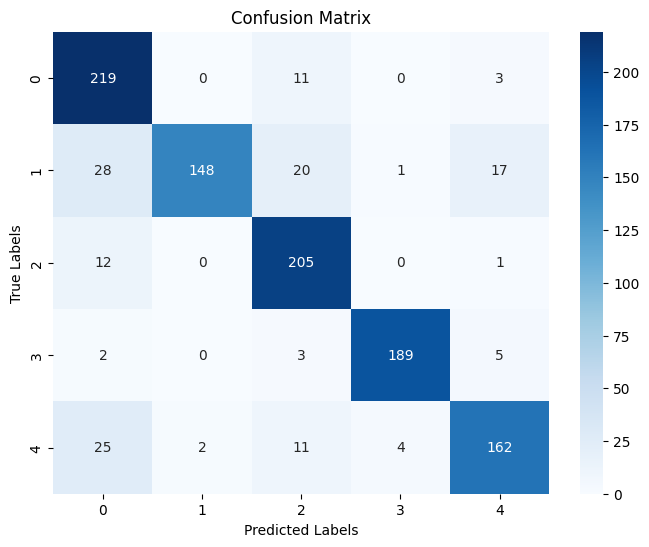

Overall Accuracy: 86.42%
              precision    recall  f1-score   support

           0       0.77      0.94      0.84       233
           1       0.99      0.69      0.81       214
           2       0.82      0.94      0.88       218
           3       0.97      0.95      0.96       199
           4       0.86      0.79      0.83       204

    accuracy                           0.86      1068
   macro avg       0.88      0.86      0.86      1068
weighted avg       0.88      0.86      0.86      1068


Class: 0
F1-Score: 0.84
Precision: 0.77
Recall: 0.94

Class: 1
F1-Score: 0.81
Precision: 0.99
Recall: 0.69

Class: 2
F1-Score: 0.88
Precision: 0.82
Recall: 0.94

Class: 3
F1-Score: 0.96
Precision: 0.97
Recall: 0.95

Class: 4
F1-Score: 0.83
Precision: 0.86
Recall: 0.79


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set the training parameters
batch_size = 128
learning_rate = 0.01
epochs = 50

# Load the dataset using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the model architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [tf.argmax(probas).numpy() for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))

# Generate classification report
report = classification_report(test_true_classes, test_preds_classes, target_names=test_generator.class_indices)
print(report)

# Calculate and print F1-score, precision, and recall for each class
f1_scores = f1_score(test_true_classes, test_preds_classes, average=None)
precisions = precision_score(test_true_classes, test_preds_classes, average=None)
recalls = recall_score(test_true_classes, test_preds_classes, average=None)
for i, label in enumerate(test_generator.class_indices):
    print(f"\nClass: {label}")
    print(f"F1-Score: {f1_scores[i]:.2f}")
    print(f"Precision: {precisions[i]:.2f}")
    print(f"Recall: {recalls[i]:.2f}")


128 0.001 50

Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Epoch 1/50
65/65 [==============================] - 36s 489ms/step - loss: 1.1723 - accuracy: 0.6227 - val_loss: 1.8285 - val_accuracy: 0.2197
Epoch 2/50
65/65 [==============================] - 32s 490ms/step - loss: 0.2206 - accuracy: 0.9237 - val_loss: 2.5234 - val_accuracy: 0.2275
Epoch 3/50
65/65 [==============================] - 32s 493ms/step - loss: 0.0837 - accuracy: 0.9744 - val_loss: 6.2584 - val_accuracy: 0.1924
Epoch 4/50
65/65 [==============================] - 32s 488ms/step - loss: 0.0707 - accuracy: 0.9757 - val_loss: 5.3034 - val_accuracy: 0.2021
Epoch 5/50
65/65 [==============================] - 32s 489ms/step - loss: 0.0394 - accuracy: 0.9874 - val_loss: 7.8010 - val_accuracy: 0.2197
Epoch 6/50
65/65 [==============================] - 32s 494ms/step - loss: 0.0329 - accuracy: 0.9880 - val_loss: 7.1361 - val_accuracy: 0.2500
Epoch 7/50
65/65

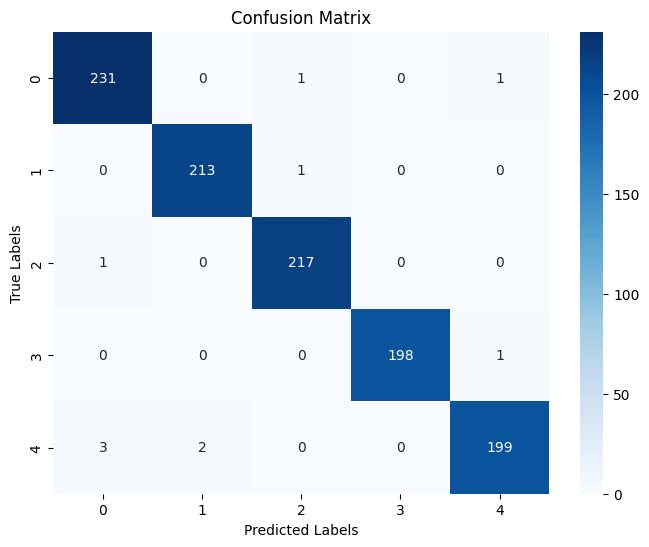

Overall Accuracy: 99.06%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       233
           1       0.99      1.00      0.99       214
           2       0.99      1.00      0.99       218
           3       1.00      0.99      1.00       199
           4       0.99      0.98      0.98       204

    accuracy                           0.99      1068
   macro avg       0.99      0.99      0.99      1068
weighted avg       0.99      0.99      0.99      1068


Class: 0
F1-Score: 0.99
Precision: 0.98
Recall: 0.99

Class: 1
F1-Score: 0.99
Precision: 0.99
Recall: 1.00

Class: 2
F1-Score: 0.99
Precision: 0.99
Recall: 1.00

Class: 3
F1-Score: 1.00
Precision: 1.00
Recall: 0.99

Class: 4
F1-Score: 0.98
Precision: 0.99
Recall: 0.98


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set the training parameters
batch_size = 128
learning_rate = 0.001
epochs = 50

# Load the dataset using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the model architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [tf.argmax(probas).numpy() for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))

# Generate classification report
report = classification_report(test_true_classes, test_preds_classes, target_names=test_generator.class_indices)
print(report)

# Calculate and print F1-score, precision, and recall for each class
f1_scores = f1_score(test_true_classes, test_preds_classes, average=None)
precisions = precision_score(test_true_classes, test_preds_classes, average=None)
recalls = recall_score(test_true_classes, test_preds_classes, average=None)
for i, label in enumerate(test_generator.class_indices):
    print(f"\nClass: {label}")
    print(f"F1-Score: {f1_scores[i]:.2f}")
    print(f"Precision: {precisions[i]:.2f}")
    print(f"Recall: {recalls[i]:.2f}")


**128 0.0001 50**

Found 8437 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Found 1068 images belonging to 5 classes.
Epoch 1/50
65/65 [==============================] - 36s 498ms/step - loss: 0.7798 - accuracy: 0.7252 - val_loss: 1.6176 - val_accuracy: 0.2021
Epoch 2/50
65/65 [==============================] - 31s 485ms/step - loss: 0.0957 - accuracy: 0.9824 - val_loss: 1.6228 - val_accuracy: 0.1914
Epoch 3/50
65/65 [==============================] - 31s 482ms/step - loss: 0.0177 - accuracy: 0.9995 - val_loss: 1.6938 - val_accuracy: 0.2070
Epoch 4/50
65/65 [==============================] - 32s 486ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.7648 - val_accuracy: 0.2227
Epoch 5/50
65/65 [==============================] - 32s 491ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.7940 - val_accuracy: 0.2646
Epoch 6/50
65/65 [==============================] - 32s 492ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.6531 - val_accuracy: 0.3496
Epoch 7/50
65/65

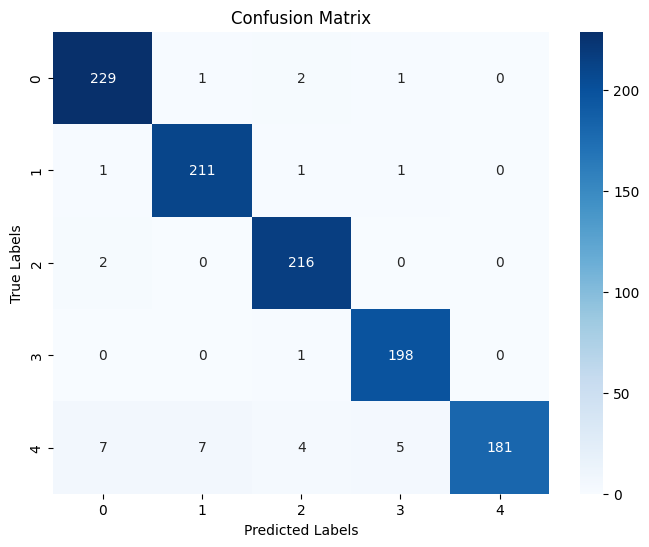

Overall Accuracy: 96.91%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       233
           1       0.96      0.99      0.97       214
           2       0.96      0.99      0.98       218
           3       0.97      0.99      0.98       199
           4       1.00      0.89      0.94       204

    accuracy                           0.97      1068
   macro avg       0.97      0.97      0.97      1068
weighted avg       0.97      0.97      0.97      1068


Class: 0
F1-Score: 0.97
Precision: 0.96
Recall: 0.98

Class: 1
F1-Score: 0.97
Precision: 0.96
Recall: 0.99

Class: 2
F1-Score: 0.98
Precision: 0.96
Recall: 0.99

Class: 3
F1-Score: 0.98
Precision: 0.97
Recall: 0.99

Class: 4
F1-Score: 0.94
Precision: 1.00
Recall: 0.89


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set the training parameters
batch_size = 128
learning_rate = 0.0001
epochs = 50

# Load the dataset using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/valid',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEW DATASET/test',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the model architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

# Evaluate the model on the test data
test_predictions = model.predict(test_generator)
test_preds_classes = [tf.argmax(probas).numpy() for probas in test_predictions]
test_true_classes = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print overall accuracy
accuracy = accuracy_score(test_true_classes, test_preds_classes)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))

# Generate classification report
report = classification_report(test_true_classes, test_preds_classes, target_names=test_generator.class_indices)
print(report)

# Calculate and print F1-score, precision, and recall for each class
f1_scores = f1_score(test_true_classes, test_preds_classes, average=None)
precisions = precision_score(test_true_classes, test_preds_classes, average=None)
recalls = recall_score(test_true_classes, test_preds_classes, average=None)
for i, label in enumerate(test_generator.class_indices):
    print(f"\nClass: {label}")
    print(f"F1-Score: {f1_scores[i]:.2f}")
    print(f"Precision: {precisions[i]:.2f}")
    print(f"Recall: {recalls[i]:.2f}")
